
Rosenbrock:

GP EI: exact versus approximate partial-order GP EI derivatives wrt **x1**, **x2**, **x3**, **x4**

In [1]:
pip install pyGPGO


  Created wheel for pyGPGO: filename=pyGPGO-0.5.1-py3-none-any.whl size=19880 sha256=10392560bb6cc2b6d8c0183c40da6d5e7072b462aca03b4d3eb40d235f2f2de6
  Stored in directory: /root/.cache/pip/wheels/c8/5d/0b/2160114e2f1b87791c51b66cf07f89831dbb6f49167950316f
Successfully built pyGPGO


In [2]:
### Import:

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import itertools

from pyGPGO.GPGO import GPGO
from pyGPGO.surrogates.GaussianProcess import GaussianProcess
from pyGPGO.acquisition import Acquisition
from pyGPGO.covfunc import squaredExponential

from joblib import Parallel, delayed
from numpy.linalg import solve, cholesky
from scipy.spatial.distance import cdist
from scipy.optimize import minimize
from scipy.stats import norm
import time

warnings.filterwarnings("ignore", category=RuntimeWarning)


In [3]:
n_start_AcqFunc = 100 #multi-start iterations to avoid local optima in AcqFunc optimization


In [4]:
### Inputs:

func = 'Rosenbrock'
n_test = 500
eps = 1e-08

util_grad_exact = 'dEI_GP'
util_grad_approx = 'ExpectedImprovement'

n_init = 5 # random initialisations
iters = 40
opt = True

In [5]:
### Objective Function - Rosenbrock(x) 4-D:

def objfunc(x1_training, x2_training, x3_training, x4_training):
            return  operator * (
                100 * (x2_training - x1_training ** 2) ** 2 + (x1_training - 1) ** 2 + 
                100 * (x3_training - x2_training ** 2) ** 2 + (x2_training - 1) ** 2 +
                100 * (x4_training - x3_training ** 2) ** 2 + (x3_training - 1) ** 2
                )
        
# Constraints:
lb = -2.048
ub = +2.048
    
# Input array dimension(s):
dim = 4

# 4-D inputs' parameter bounds:
param = {'x1_training': ('cont', [lb, ub]),
                 'x2_training': ('cont', [lb, ub]),
                 'x3_training': ('cont', [lb, ub]),
                 'x4_training': ('cont', [lb, ub])}
    
# True y bounds:
y_lb = 0
operator = -1 # targets global minimum 
y_global_orig = y_lb * operator # targets global minimum
    
# Test data:
x1_test = np.linspace(lb, ub, n_test)
x2_test = np.linspace(lb, ub, n_test)
x3_test = np.linspace(lb, ub, n_test)
x4_test = np.linspace(lb, ub, n_test)
Xstar = np.column_stack((x1_test, x2_test, x3_test, x4_test))

Xstar_d = np.column_stack((x1_test, x2_test, x3_test))
    

In [6]:
### Cumulative Regret Calculator:

def min_max_array(x):
    new_list = []
    for i, num in enumerate(x):
            new_list.append(np.min(x[0:i+1]))
    return new_list
  

In [7]:
### Surrogate derivatives: 

cov_func = squaredExponential()

def kronDelta(X, Xstar):
    return cdist(X, Xstar) < np.finfo(np.float32).eps

def se(X, Xstar, sigmaf, l, sigman):
    return sigmaf * np.exp(-0.5 * cdist(X, Xstar) ** 2 / l ** 2) + sigman * kronDelta(X, Xstar)

def deriv_se(X, Xstar, sigmaf, l, sigman):
    return cdist(X, Xstar) / (l ** 2) * se(X, Xstar, sigmaf, l, sigman)

def der_covmat(X, Xstar, sigmaf, l, sigman):
      nx = len(X)
      ny = len(Xstar)
      return np.round(np.array([deriv_se(np.atleast_2d(i), np.atleast_2d(j), sigmaf, l, sigman) for (i, j) in itertools.product(X, Xstar)]).reshape(nx, ny), 8)

class dGaussianProcess(GaussianProcess):
    l = GaussianProcess(cov_func, optimize=opt).getcovparams()['l']
    sigmaf = GaussianProcess(cov_func, optimize=opt).getcovparams()['sigmaf']
    sigman = GaussianProcess(cov_func, optimize=opt).getcovparams()['sigman']

    def AcqGrad(self, Xstar):
        Xstar = np.atleast_2d(Xstar)
        Kstar = self.covfunc.K(self.X, Xstar).T
        dKstar = der_covmat(self.X, Xstar, self.sigmaf, self.l, self.sigman).T
        
        alpha_Kstar = np.dot(np.linalg.inv(self.K + (self.sigman**2) * np.eye(len(self.X))), Kstar.T)
        
        dm = np.dot(-dKstar, self.alpha)
        ds = -2 * np.dot(-dKstar, alpha_Kstar)
        
        return dm, ds
        

In [8]:
class Acquisition_new(Acquisition):    
    def __init__(self, mode, eps=eps, **params):
        
        self.params = params
        self.eps = eps

        mode_dict = {
            'dEI_GP': self.dEI_GP
        }

        self.f = mode_dict[mode]
    
    def dEI_GP(self, tau, mean, std, ds, dm):
        gamma = (mean - tau - self.eps) / (std + self.eps)
        gamma_h = (mean - tau) / (std + self.eps)
        dsdx = ds / (2 * (std + self.eps))
        dmdx = (dm - gamma * dsdx) / (std + self.eps)
        
        f = (std + self.eps) * (gamma * norm.cdf(gamma) + norm.pdf(gamma))
        df1 = f / (std + self.eps) * dsdx 
        df2 = (std + self.eps) * norm.cdf(gamma) * dmdx
        df = (df1 + df2)[0]
        df_arr = []

        for j in range(0, dim):
          df_arr.append(df)
        return f, np.asarray(df_arr).transpose()
        
    def d_eval(self, tau, mean, std, ds, dm):
    
        return self.f(tau, mean, std, ds, dm, **self.params)
        

In [9]:
## dGPGO:

grad = 1

class dGPGO(GPGO):
    n_start = n_start_AcqFunc

    def d_optimizeAcq(self, method='L-BFGS-B', n_start=n_start_AcqFunc):
        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfunc,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = True,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])

        self.x_best = x_best
        self.f_best = f_best
        self.best = x_best[np.argmin(f_best)]
        self.start_points_arr = start_points_arr

        return x_best, f_best
    
    def run(self, max_iter=10, init_evals=3, resume=False):
        
        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self.logger._printInit(self)
        for iteration in range(max_iter):
            self.d_optimizeAcq()
            self.updateGP()
            self.logger._printCurrent(self)

    def acqfunc(self, xnew, n_start=n_start_AcqFunc):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm)

        return -f, -df * grad

    def acqfunc_h(self, xnew, n_start=n_start_AcqFunc, eps=eps):
        f = self.acqfunc(xnew)[0]
        
        new_mean_h, new_var_h = self.GP.predict(xnew + eps, return_std=True)
        new_std_h = np.sqrt(new_var_h + eps)
        dm_h, ds_h = self.GP.AcqGrad(xnew + eps)
        f_h = self.A.d_eval(-self.tau, new_mean_h, new_std_h, ds=ds_h, dm=dm_h)[0]
        
        approx_grad = (-f_h - f)/eps
        return approx_grad


In [10]:
###Reproducible set-seeds:

run_num_1 = 1
run_num_2 = 2
run_num_3 = 3
run_num_4 = 4
run_num_5 = 5
run_num_6 = 6
run_num_7 = 7
run_num_8 = 8
run_num_9 = 9
run_num_10 = 10
run_num_11 = 11
run_num_12 = 12
run_num_13 = 13
run_num_14 = 14
run_num_15 = 15
run_num_16 = 16
run_num_17 = 17
run_num_18 = 18
run_num_19 = 19
run_num_20 = 20


In [11]:
start_approx = time.time()
start_approx


1629305795.6639335

In [12]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_1)
surrogate_approx_1 = GaussianProcess(cov_func, optimize=opt)

approx_1 = GPGO(surrogate_approx_1, Acquisition(util_grad_approx), objfunc, param)
approx_1.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-0.33987787  0.90244913 -2.04753152 -0.80964578]. 	  -3394.123441866637 	 -59.369079192709535
init   	 [-1.44688787 -1.66978112 -1.28507817 -0.63258326]. 	  -3615.357417364757 	 -59.369079192709535
init   	 [-0.42284043  0.15899334 -0.33097927  0.75865907]. 	  -59.369079192709535 	 -59.369079192709535
init   	 [-1.21056359  1.54876902 -1.93582042  0.69823492]. 	  -2823.036073483468 	 -59.369079192709535
init   	 [-0.33871953  0.24039354 -1.4729751  -1.2365763 ]. 	  -1404.6293821132788 	 -59.369079192709535
1      	 [-0.0490961   0.0026703   0.52114175  1.27606514]. 	  -130.3799970253568 	 -59.369079192709535
2      	 [ 2.048 -2.048  2.048 -2.048]. 	  -8265.420843724798 	 -59.369079192709535
3      	 [-2.048  2.048  2.048 -2.048]. 	  -4829.447006924799 	 -59.369079192709535
4      	 [ 2.048 -2.048 -2.048  2.048]. 	  -8273.612843724799 	 -59.369079192709535
5      	 [2.048 2.048 2.048 2.048]. 	  -1385.2811701248 	 -59.36

In [13]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_2)
surrogate_approx_2 = GaussianProcess(cov_func, optimize=opt)

approx_2 = GPGO(surrogate_approx_2, Acquisition(util_grad_approx), objfunc, param)
approx_2.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-0.26216488 -1.94180615  0.20341751 -0.26491948]. 	  -1696.9764582030691 	 -291.50084682592353
init   	 [-0.32617348 -0.69494857 -1.20975919  0.48853388]. 	  -455.3157381798458 	 -291.50084682592353
init   	 [-0.82061446 -0.95507548  0.49616418  0.11936602]. 	  -291.50084682592353 	 -291.50084682592353
init   	 [-1.49676054  0.05561598 -1.29253431  1.16873277]. 	  -682.7190038869136 	 -291.50084682592353
init   	 [ 1.4498828  -0.02360591  1.41951584 -1.72177213]. 	  -2051.02408589455 	 -291.50084682592353
1      	 [-1.86778037  0.18049011  2.00280848  0.51009437]. 	  -2718.2474715699536 	 -291.50084682592353
2      	 [ 2.048  2.048 -2.048  2.048]. 	  -4829.447006924799 	 -291.50084682592353
3      	 [-2.048  2.048 -2.048 -2.048]. 	  -8273.612843724799 	 -291.50084682592353
4      	 [2.048 2.048 2.048 2.048]. 	  -1385.2811701248 	 -291.50084682592353
5      	 [ 2.048 -2.048  2.048  2.048]. 	  -4829.447006924799 	 -291.5

In [14]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_3)
surrogate_approx_3 = GaussianProcess(cov_func, optimize=opt)

approx_3 = GPGO(surrogate_approx_3, Acquisition(util_grad_approx), objfunc, param)
approx_3.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 0.20806821  0.85257348 -0.85645419  0.04434987]. 	  -367.7787956485136 	 -171.0831542888061
init   	 [ 1.60951073  1.62321649 -1.53360257 -1.19913317]. 	  -3099.341888277455 	 -171.0831542888061
init   	 [-1.83719034 -0.24244288 -1.92562704 -0.17681111]. 	  -3229.929027395333 	 -171.0831542888061
init   	 [ 0.61089402 -0.90731609  0.72194008  0.3721741 ]. 	  -171.0831542888061 	 -171.0831542888061
init   	 [-1.94977021  0.24106634 -0.98610198 -0.3477455 ]. 	  -1564.2806119712143 	 -171.0831542888061
1      	 [-2.048  2.048  2.048  2.048]. 	  -1393.4731701248 	 -171.0831542888061
2      	 [-2.048 -2.048  2.048 -2.048]. 	  -8273.612843724797 	 -171.0831542888061
3      	 [ 2.048 -2.048 -2.048  2.048]. 	  -8273.612843724799 	 -171.0831542888061
4      	 [2.048 2.048 2.048 2.048]. 	  -1385.2811701248 	 -171.0831542888061
5      	 [-0.35345106  2.048       2.048      -2.048     ]. 	  -4731.147173102215 	 -171.0831542888061

In [15]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_4)
surrogate_approx_4 = GaussianProcess(cov_func, optimize=opt)

approx_4 = GPGO(surrogate_approx_4, Acquisition(util_grad_approx), objfunc, param)
approx_4.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [1.91295422 0.19346329 1.93611514 0.87988631]. 	  -2387.047477734054 	 -936.5671269056027
init   	 [ 0.80989727 -1.16289743  1.95082017 -2.02248087]. 	  -3769.0203854501506 	 -936.5671269056027
init   	 [-1.01178424 -0.26709388  1.14435245 -1.23828193]. 	  -936.5671269056027 	 -936.5671269056027
init   	 [ 1.48682029  1.98000917 -1.37690218  0.39867983]. 	  -3042.500138281922 	 -936.5671269056027
init   	 [-2.01119294 -0.46460403 -1.8671204   1.87045056]. 	  -2747.9169599921197 	 -936.5671269056027
1      	 [-2.048  2.048  2.048  2.048]. 	  -1393.4731701248 	 -936.5671269056027
2      	 [ 2.048 -2.048 -2.048  2.048]. 	  -8273.612843724799 	 -936.5671269056027
3      	 [-2.048  2.048 -2.048 -2.048]. 	  -8273.612843724799 	 -936.5671269056027
4      	 [-2.048 -2.048  2.048  2.048]. 	  -4837.639006924799 	 -936.5671269056027
5      	 [ 0.01575257 -2.048      -2.048      -2.048     ]. 	  -8232.353242429861 	 -936.5671269056

In [16]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_5)
surrogate_approx_5 = GaussianProcess(cov_func, optimize=opt)

approx_5 = GPGO(surrogate_approx_5, Acquisition(util_grad_approx), objfunc, param)
approx_5.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-1.13871597  1.51851953 -1.20127834  1.71463028]. 	  -1252.0157320257063 	 -100.45329155979191
init   	 [-0.04746777  0.45770286  1.08915858  0.07544008]. 	  -222.91752416760144 	 -100.45329155979191
init   	 [-0.83230515 -1.27909385 -1.71728376  0.97665145]. 	  -1918.291410223084 	 -100.45329155979191
init   	 [-0.24039742 -1.39956278  1.55622208 -0.92534185]. 	  -1356.5528565009568 	 -100.45329155979191
init   	 [-0.35129336 -0.8352566   0.52751527  0.32701567]. 	  -100.45329155979191 	 -100.45329155979191
1      	 [ 2.048  2.048 -2.048 -2.048]. 	  -8265.4208437248 	 -100.45329155979191
2      	 [ 2.048      -2.048       1.01658064  2.048     ]. 	  -5019.751351509129 	 -100.45329155979191
3      	 [-2.048  2.048  2.048 -2.048]. 	  -4829.447006924799 	 -100.45329155979191
4      	 [2.048 2.048 2.048 2.048]. 	  -1385.2811701248 	 -100.45329155979191
5      	 [-2.048      -0.78793203  2.048       2.048     ]. 	  -3160.1

In [17]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_6)
surrogate_approx_6 = GaussianProcess(cov_func, optimize=opt)

approx_6 = GPGO(surrogate_approx_6, Acquisition(util_grad_approx), objfunc, param)
approx_6.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 1.60915518 -0.68821072  1.31575449 -1.87721062]. 	  -2450.5677149947023 	 -111.72625934007624
init   	 [-1.60703824  0.38933325  0.12213192 -0.33256477]. 	  -501.1308148976547 	 -111.72625934007624
init   	 [-0.67416945  0.50183959 -0.25337272  0.96617311]. 	  -111.72625934007624 	 -111.72625934007624
init   	 [0.07387714 0.32300483 0.59537447 2.00795862]. 	  -309.07782450458865 	 -111.72625934007624
init   	 [ 1.31013917 -0.35552897  1.54119232  1.32611864]. 	  -741.7784291682051 	 -111.72625934007624
1      	 [ 2.048       2.048      -2.048      -0.16855141]. 	  -6272.235654950075 	 -111.72625934007624
2      	 [-2.048 -2.048 -2.048  2.048]. 	  -8281.8048437248 	 -111.72625934007624
3      	 [-0.31768625 -2.048      -2.048      -2.048     ]. 	  -8275.376423859392 	 -111.72625934007624
4      	 [-2.048 -2.048  2.048 -2.048]. 	  -8273.612843724797 	 -111.72625934007624
5      	 [ 2.048 -2.048 -2.048  2.048]. 	  -8273.

In [18]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_7)
surrogate_approx_7 = GaussianProcess(cov_func, optimize=opt)

approx_7 = GPGO(surrogate_approx_7, Acquisition(util_grad_approx), objfunc, param)
approx_7.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-1.73544125  1.14654737 -0.25227579  0.91531337]. 	  -675.0078283253545 	 -189.504451516756
init   	 [ 1.95784504  0.15767909  0.00458942 -1.75287856]. 	  -1660.8385633941034 	 -189.504451516756
init   	 [-9.48473938e-01 -4.81276619e-04  7.34126064e-01  1.24411509e+00]. 	  -189.504451516756 	 -189.504451516756
init   	 [-0.48766512 -1.77792472 -0.86775563  1.67769509]. 	  -2128.346574385609 	 -189.504451516756
init   	 [-1.17397359 -0.19610025  1.76621986 -1.94601276]. 	  -3119.0824429471622 	 -189.504451516756
1      	 [2.048 2.048 2.048 2.048]. 	  -1385.2811701248 	 -189.504451516756
2      	 [ 2.048  2.048 -2.048  2.048]. 	  -4829.447006924799 	 -189.504451516756
3      	 [-2.048 -2.048 -2.048 -2.048]. 	  -11717.778680524798 	 -189.504451516756
4      	 [ 2.048 -2.048  2.048  2.048]. 	  -4829.447006924799 	 -189.504451516756
5      	 [-0.76407837  2.048      -2.048      -2.048     ]. 	  -8021.155976492433 	 -189.504

In [19]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_8)
surrogate_approx_8 = GaussianProcess(cov_func, optimize=opt)

approx_8 = GPGO(surrogate_approx_8, Acquisition(util_grad_approx), objfunc, param)
approx_8.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [1.52956683 1.91914255 1.51222084 0.12638491]. 	  -957.0835831104033 	 -9.936266004845226
init   	 [-1.09474477 -2.0013105  -0.28479972 -0.39996883]. 	  -2902.49459403014 	 -9.936266004845226
init   	 [ 0.09287545 -0.0885072   0.22674012  0.17770913]. 	  -9.936266004845226 	 -9.936266004845226
init   	 [ 1.06862828  0.86988626  0.49021787 -0.30272811]. 	  -44.27508698465467 	 -9.936266004845226
init   	 [-0.86394869  1.94091107 -0.68086151 -1.15179085]. 	  -2389.276657793903 	 -9.936266004845226
1      	 [ 2.048      -0.23418835 -2.048       2.048     ]. 	  -2875.9237346807367 	 -9.936266004845226
2      	 [ 2.048 -2.048  2.048  2.048]. 	  -4829.447006924799 	 -9.936266004845226
3      	 [-2.048      0.8073882  2.048      2.048    ]. 	  -1813.12396018947 	 -9.936266004845226
4      	 [ 2.048      -0.77107626 -2.048      -2.048     ]. 	  -7073.972948181394 	 -9.936266004845226
5      	 [ 2.048 -2.048  2.048 -2.048]. 	  -

In [20]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_9)
surrogate_approx_9 = GaussianProcess(cov_func, optimize=opt)

approx_9 = GPGO(surrogate_approx_9, Acquisition(util_grad_approx), objfunc, param)
approx_9.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-2.00550747  0.00767833 -0.01731259 -1.49983425]. 	  -1847.6492499405208 	 -460.72675701107613
init   	 [-1.46591299 -1.15278366 -0.33379049 -1.03177761]. 	  -1509.7528388540472 	 -460.72675701107613
init   	 [-1.70369167 -0.63283757 -1.36488408  1.55057801]. 	  -1586.883400641493 	 -460.72675701107613
init   	 [ 1.84714867 -1.88928665  0.81554388  0.2980242 ]. 	  -3591.2693050622433 	 -460.72675701107613
init   	 [1.63023716 0.68361819 0.19594356 0.82914273]. 	  -460.72675701107613 	 -460.72675701107613
1      	 [-2.048  2.048  2.048  2.048]. 	  -1393.4731701248 	 -460.72675701107613
2      	 [ 2.048  2.048 -2.048 -2.048]. 	  -8265.4208437248 	 -460.72675701107613
3      	 [ 0.745632  2.048     2.048    -2.048   ]. 	  -4582.175544663847 	 -460.72675701107613
4      	 [-2.048 -2.048  2.048  2.048]. 	  -4837.639006924799 	 -460.72675701107613
5      	 [ 2.048 -2.048 -2.048 -2.048]. 	  -11709.586680524799 	 -460.72675701

In [21]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_10)
surrogate_approx_10 = GaussianProcess(cov_func, optimize=opt)

approx_10 = GPGO(surrogate_approx_10, Acquisition(util_grad_approx), objfunc, param)
approx_10.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 1.11132935 -1.96300002  0.54742317  1.0191007 ]. 	  -2176.436426889387 	 -787.6933551437477
init   	 [-0.00611528 -1.12723294 -1.23673451  1.0671338 ]. 	  -787.6933551437477 	 -787.6933551437477
init   	 [-1.35532201 -1.68616012  0.75923382  1.85709915]. 	  -1852.2892745062024 	 -787.6933551437477
init   	 [-2.0318279   0.04993951  1.28049546  0.46090677]. 	  -1975.7725172569656 	 -787.6933551437477
init   	 [ 0.90830978 -0.85247562  1.71120281  0.87890241]. 	  -802.2371849082838 	 -787.6933551437477
1      	 [ 2.048  2.048 -2.048 -2.048]. 	  -8265.4208437248 	 -787.6933551437477
2      	 [-2.048 -2.048 -2.048 -2.048]. 	  -11717.778680524798 	 -787.6933551437477
3      	 [-2.048  2.048 -2.048  2.048]. 	  -4837.639006924799 	 -787.6933551437477
4      	 [ 0.47780069  2.048       2.048      -2.048     ]. 	  -4690.900483469856 	 -787.6933551437477
5      	 [ 2.048       2.048      -0.02364472  2.048     ]. 	  -2662.21711

In [22]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_11)
surrogate_approx_11 = GaussianProcess(cov_func, optimize=opt)

approx_11 = GPGO(surrogate_approx_11, Acquisition(util_grad_approx), objfunc, param)
approx_11.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-1.30961535 -1.96822941 -0.15065692  0.92132937]. 	  -3072.6361628465456 	 -1084.6194797620587
init   	 [-0.32684604 -0.05969061 -1.99564978 -0.0517259 ]. 	  -2041.908514926983 	 -1084.6194797620587
init   	 [ 1.80964005  1.43685669  0.94193447 -1.60261705]. 	  -1084.6194797620587 	 -1084.6194797620587
init   	 [ 1.61343148  1.4629038  -1.37180521  0.54204012]. 	  -1549.0827052305292 	 -1084.6194797620587
init   	 [-1.96409912 -1.56984415 -0.75215949 -1.40119119]. 	  -4385.783412609677 	 -1084.6194797620587
1      	 [-2.048  2.048  2.048  2.048]. 	  -1393.4731701248 	 -1084.6194797620587
2      	 [ 2.048      -0.91250438  2.048       2.048     ]. 	  -3222.169648290899 	 -1084.6194797620587
3      	 [-2.048  2.048  2.048 -2.048]. 	  -4829.447006924799 	 -1084.6194797620587
4      	 [ 2.048 -2.048  2.048 -2.048]. 	  -8265.420843724798 	 -1084.6194797620587
5      	 [ 2.048 -2.048 -2.048  2.048]. 	  -8273.612843724799 	 -

In [23]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_12)
surrogate_approx_12 = GaussianProcess(cov_func, optimize=opt)

approx_12 = GPGO(surrogate_approx_12, Acquisition(util_grad_approx), objfunc, param)
approx_12.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-1.416549    0.98324356 -0.9694617   0.13819656]. 	  -553.611160809845 	 -553.611160809845
init   	 [-1.98830095  1.71518775  1.64132804 -1.91110583]. 	  -2800.5873266661606 	 -553.611160809845
init   	 [ 1.87166448 -1.48599062 -0.88543907  0.43451672]. 	  -3468.8797831248744 	 -553.611160809845
init   	 [ 1.81954616  1.44480478 -2.03874618  0.08694181]. 	  -3716.955397581154 	 -553.611160809845
init   	 [ 0.21314615 -0.05989411  1.0982775  -1.38970418]. 	  -796.5750150214192 	 -553.611160809845
1      	 [-2.048 -2.048  2.048  2.048]. 	  -4837.639006924799 	 -553.611160809845
2      	 [2.048 2.048 2.048 2.048]. 	  -1385.2811701248 	 -553.611160809845
3      	 [-2.048 -2.048 -2.048 -2.048]. 	  -11717.778680524798 	 -553.611160809845
4      	 [-2.048  2.048  2.048  2.048]. 	  -1393.4731701248 	 -553.611160809845
5      	 [-2.048 -2.048 -2.048  2.048]. 	  -8281.8048437248 	 -553.611160809845
6      	 [ 2.048  2.048  2.048

In [24]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_13)
surrogate_approx_13 = GaussianProcess(cov_func, optimize=opt)

approx_13 = GPGO(surrogate_approx_13, Acquisition(util_grad_approx), objfunc, param)
approx_13.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 1.13746907 -1.07503116  1.32824487  1.90770872]. 	  -570.621446040192 	 -570.621446040192
init   	 [ 1.93577416 -0.19067188  0.44663793  1.1285566 ]. 	  -1656.450565242978 	 -570.621446040192
init   	 [ 0.58004826  0.90938667 -1.9044904  -0.82555097]. 	  -2770.1364153691793 	 -570.621446040192
init   	 [-1.80833283  1.46252162 -0.5207899   0.73665721]. 	  -1066.23070619416 	 -570.621446040192
init   	 [-0.99827733 -0.62430734 -2.00944529 -0.58026483]. 	  -2986.7442974027663 	 -570.621446040192
1      	 [-2.048 -2.048  2.048 -2.048]. 	  -8273.612843724797 	 -570.621446040192
2      	 [ 2.048  2.048  2.048 -2.048]. 	  -4821.255006924799 	 -570.621446040192
3      	 [-2.048 -2.048  2.048  2.048]. 	  -4837.639006924799 	 -570.621446040192
4      	 [ 2.048      -2.048       0.37059336 -2.048     ]. 	  -5847.067836379805 	 -570.621446040192
5      	 [-2.048  2.048  2.048 -2.048]. 	  -4829.447006924799 	 -570.621446040192
6 

In [25]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_14)
surrogate_approx_14 = GaussianProcess(cov_func, optimize=opt)

approx_14 = GPGO(surrogate_approx_14, Acquisition(util_grad_approx), objfunc, param)
approx_14.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 0.05711194  1.11888405  1.5172718  -2.0150397 ]. 	  -1996.4555487728376 	 -635.6383005184798
init   	 [-0.77932165  1.87434492  0.05372605 -0.744307  ]. 	  -1417.9597465038332 	 -635.6383005184798
init   	 [ 0.16056294 -1.14173976  1.25534764 -0.64612505]. 	  -635.6383005184798 	 -635.6383005184798
init   	 [ 0.15928873 -2.02394097  0.70923255 -1.18774062]. 	  -1863.0160368222728 	 -635.6383005184798
init   	 [ 1.7717559  -0.51509351  1.0339079   1.07781735]. 	  -1397.2995170993763 	 -635.6383005184798
1      	 [-2.048 -2.048 -2.048  2.048]. 	  -8281.8048437248 	 -635.6383005184798
2      	 [ 2.048  2.048 -2.048  2.048]. 	  -4829.447006924799 	 -635.6383005184798
3      	 [-2.048       0.19015951  2.048       2.048     ]. 	  -2479.773608431594 	 -635.6383005184798
4      	 [ 2.048       0.13381568 -2.048      -2.048     ]. 	  -5983.328365860246 	 -635.6383005184798
5      	 [-2.048      -0.89703731 -2.048      -2.048 

In [26]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_15)
surrogate_approx_15 = GaussianProcess(cov_func, optimize=opt)

approx_15 = GPGO(surrogate_approx_15, Acquisition(util_grad_approx), objfunc, param)
approx_15.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 1.42875729 -1.31524229 -1.82532827 -0.56713852]. 	  -3924.3244166004847 	 -330.9329217994366
init   	 [-0.9199578   0.12288092 -0.79495612 -0.80087302]. 	  -330.9329217994366 	 -330.9329217994366
init   	 [-1.59030773 -1.02441364  1.71061206 -0.96605449]. 	  -2832.720279494954 	 -330.9329217994366
init   	 [ 0.89200102  1.49796878  1.25779756 -1.18558481]. 	  -912.8737542795088 	 -330.9329217994366
init   	 [-1.36297254 -1.85669062 -1.88652621 -1.2278546 ]. 	  -6538.09169222112 	 -330.9329217994366
1      	 [-2.048  2.048 -2.048  2.048]. 	  -4837.639006924799 	 -330.9329217994366
2      	 [ 2.048 -2.048  2.048  2.048]. 	  -4829.447006924799 	 -330.9329217994366
3      	 [ 2.048       2.048      -0.61717139  2.048     ]. 	  -3058.4255477766123 	 -330.9329217994366
4      	 [-2.048  2.048  2.048  2.048]. 	  -1393.4731701248 	 -330.9329217994366
5      	 [ 2.048 -2.048  2.048 -2.048]. 	  -8265.420843724798 	 -330.9329217

In [27]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_16)
surrogate_approx_16 = GaussianProcess(cov_func, optimize=opt)

approx_16 = GPGO(surrogate_approx_16, Acquisition(util_grad_approx), objfunc, param)
approx_16.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-1.13339974  0.09487705  0.20767317 -1.86121441]. 	  -514.1403917485846 	 -460.11665987879945
init   	 [-0.57045469 -1.13426046  0.77302236 -1.37735608]. 	  -636.540695155299 	 -460.11665987879945
init   	 [-1.75994935  1.80638048  0.26083893 -1.72854338]. 	  -1399.5661404272828 	 -460.11665987879945
init   	 [ 0.91193553 -1.3989799  -1.02284777 -0.8458762 ]. 	  -1753.4526459251956 	 -460.11665987879945
init   	 [ 0.80531749 -0.1463743  -1.16710546 -0.21779963]. 	  -460.11665987879945 	 -460.11665987879945
1      	 [2.048 2.048 2.048 2.048]. 	  -1385.2811701248 	 -460.11665987879945
2      	 [-2.048  2.048 -2.048  2.048]. 	  -4837.639006924799 	 -460.11665987879945
3      	 [-2.048 -2.048  2.048  2.048]. 	  -4837.639006924799 	 -460.11665987879945
4      	 [ 2.048  2.048  2.048 -2.048]. 	  -4821.255006924799 	 -460.11665987879945
5      	 [ 2.048 -2.048  2.048  2.048]. 	  -4829.447006924799 	 -460.11665987879945
6     

In [28]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_17)
surrogate_approx_17 = GaussianProcess(cov_func, optimize=opt)

approx_17 = GPGO(surrogate_approx_17, Acquisition(util_grad_approx), objfunc, param)
approx_17.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-0.84105215  0.12528335 -1.26353086 -1.76988013]. 	  -1340.0610302924795 	 -57.67854505088549
init   	 [1.17549244 0.64034211 0.56328559 0.30966945]. 	  -57.67854505088549 	 -57.67854505088549
init   	 [-1.8879983  -0.58239548  1.82551833 -1.80205699]. 	  -4588.535377497626 	 -57.67854505088549
init   	 [ 1.49111646  1.545382   -1.83831075  0.62430665]. 	  -2599.959730636226 	 -57.67854505088549
init   	 [ 0.21197361  0.39941429 -0.06746675 -0.88888049]. 	  -99.66183844529772 	 -57.67854505088549
1      	 [ 2.048 -2.048  2.048  2.048]. 	  -4829.447006924799 	 -57.67854505088549
2      	 [ 2.048       1.05649593  1.32151056 -2.048     ]. 	  -2429.744400124792 	 -57.67854505088549
3      	 [-0.55463032  2.048       2.048       2.048     ]. 	  -1228.8317229579275 	 -57.67854505088549
4      	 [-2.048 -2.048 -2.048  2.048]. 	  -8281.8048437248 	 -57.67854505088549
5      	 [ 2.048 -2.048 -2.048 -2.048]. 	  -11709.586680524

In [29]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_18)
surrogate_approx_18 = GaussianProcess(cov_func, optimize=opt)

approx_18 = GPGO(surrogate_approx_18, Acquisition(util_grad_approx), objfunc, param)
approx_18.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 0.61593289  0.02233702  1.55075162 -1.30318244]. 	  -1629.4185602457633 	 -361.44679331797425
init   	 [1.44274665 1.02455823 0.68035243 1.99841976]. 	  -361.44679331797425 	 -361.44679331797425
init   	 [-0.99545734 -1.93205893  0.5559055   1.42259154]. 	  -2000.4660253561508 	 -361.44679331797425
init   	 [ 0.96737126 -1.96277407 -1.59087358 -0.82852355]. 	  -4947.239458116178 	 -361.44679331797425
init   	 [ 0.7658299   1.48122033 -1.23439366  0.64384627]. 	  -1338.1489953342577 	 -361.44679331797425
1      	 [-2.048  2.048  2.048  2.048]. 	  -1393.4731701248 	 -361.44679331797425
2      	 [-2.048  2.048 -2.048 -2.048]. 	  -8273.612843724799 	 -361.44679331797425
3      	 [-2.048 -2.048  2.048 -2.048]. 	  -8273.612843724797 	 -361.44679331797425
4      	 [ 2.048 -2.048  2.048  2.048]. 	  -4829.447006924799 	 -361.44679331797425
5      	 [-2.048       0.39550459 -2.048       2.048     ]. 	  -2408.6442678719914 	 -36

In [30]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_19)
surrogate_approx_19 = GaussianProcess(cov_func, optimize=opt)

approx_19 = GPGO(surrogate_approx_19, Acquisition(util_grad_approx), objfunc, param)
approx_19.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-1.64850237  1.07007884 -1.03654206 -1.48221261]. 	  -1412.165722504925 	 -422.65196913661765
init   	 [-0.69039488 -1.70803378  0.70441812  1.2558082 ]. 	  -1034.97990396323 	 -422.65196913661765
init   	 [ 1.97731088  0.55566637 -1.16357834  0.20081636]. 	  -1480.569995327432 	 -422.65196913661765
init   	 [ 1.86613588e-01 -1.08922440e+00 -1.58217895e+00 -1.39564217e-03]. 	  -1531.8962214288383 	 -422.65196913661765
init   	 [-1.4249639   0.13388219 -0.46282028  0.77138896]. 	  -422.65196913661765 	 -422.65196913661765
1      	 [ 2.048 -2.048  2.048 -2.048]. 	  -8265.420843724798 	 -422.65196913661765
2      	 [0.83916702 2.048      2.048      2.048     ]. 	  -1104.1261463880821 	 -422.65196913661765
3      	 [ 0.60943483  2.048       2.048      -2.048     ]. 	  -4640.742289311788 	 -422.65196913661765
4      	 [-2.048 -2.048  2.048 -2.048]. 	  -8273.612843724797 	 -422.65196913661765
5      	 [-2.048  2.048 -2.048  

In [31]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_20)
surrogate_approx_20 = GaussianProcess(cov_func, optimize=opt)

approx_20 = GPGO(surrogate_approx_20, Acquisition(util_grad_approx), objfunc, param)
approx_20.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.36098376 1.62903543 1.60370987 1.29367031]. 	  -499.42964684869025 	 -499.42964684869025
init   	 [-1.90099626  0.78543905 -0.49692286  0.07582083]. 	  -937.6489569337288 	 -499.42964684869025
init   	 [ 0.6469692  -1.25398951 -0.93259202  0.8954099 ]. 	  -916.294647636079 	 -499.42964684869025
init   	 [ 1.15918278  1.43494201  1.12740309 -1.897823  ]. 	  -1092.029190829674 	 -499.42964684869025
init   	 [-1.57002246  1.02924575 -1.06816219 -1.00431457]. 	  -1129.8679642787797 	 -499.42964684869025
1      	 [-2.048 -2.048  2.048 -2.048]. 	  -8273.612843724797 	 -499.42964684869025
2      	 [ 2.048  2.048 -2.048  2.048]. 	  -4829.447006924799 	 -499.42964684869025
3      	 [ 2.048 -2.048  2.048  2.048]. 	  -4829.447006924799 	 -499.42964684869025
4      	 [ 2.048 -2.048 -2.048 -2.048]. 	  -11709.586680524799 	 -499.42964684869025
5      	 [-2.048      -1.31218948  2.048       2.048     ]. 	  -3519.181909230178 	 -499

In [32]:
end_approx = time.time()
end_approx

time_approx = end_approx - start_approx
time_approx

start_exact = time.time()
start_exact

1629306637.6459687

In [33]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_1)
surrogate_exact_1 = dGaussianProcess(cov_func, optimize=opt)

exact_1 = dGPGO(surrogate_exact_1, Acquisition_new(util_grad_exact), objfunc, param)
exact_1.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-0.33987787  0.90244913 -2.04753152 -0.80964578]. 	  -3394.123441866637 	 -59.369079192709535
init   	 [-1.44688787 -1.66978112 -1.28507817 -0.63258326]. 	  -3615.357417364757 	 -59.369079192709535
init   	 [-0.42284043  0.15899334 -0.33097927  0.75865907]. 	  -59.369079192709535 	 -59.369079192709535
init   	 [-1.21056359  1.54876902 -1.93582042  0.69823492]. 	  -2823.036073483468 	 -59.369079192709535
init   	 [-0.33871953  0.24039354 -1.4729751  -1.2365763 ]. 	  -1404.6293821132788 	 -59.369079192709535
1      	 [0.21425057 0.30757233 0.29400518 1.39162537]. 	  -182.7697018045233 	 -59.369079192709535
2      	 [ 2.048      -1.33949537  2.048      -1.05366955]. 	  -5830.525049964835 	 -59.369079192709535
3      	 [2.048 2.048 2.048 2.048]. 	  -1385.2811701248 	 -59.369079192709535
4      	 [-1.03173544  1.41563889  1.99343081 -1.77532599]. 	  -3322.836591704889 	 -59.369079192709535
5      	 [-1.51268219  0.14746655 

In [34]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_2)
surrogate_exact_2 = dGaussianProcess(cov_func, optimize=opt)

exact_2 = dGPGO(surrogate_exact_2, Acquisition_new(util_grad_exact), objfunc, param)
exact_2.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-0.26216488 -1.94180615  0.20341751 -0.26491948]. 	  -1696.9764582030691 	 -291.50084682592353
init   	 [-0.32617348 -0.69494857 -1.20975919  0.48853388]. 	  -455.3157381798458 	 -291.50084682592353
init   	 [-0.82061446 -0.95507548  0.49616418  0.11936602]. 	  -291.50084682592353 	 -291.50084682592353
init   	 [-1.49676054  0.05561598 -1.29253431  1.16873277]. 	  -682.7190038869136 	 -291.50084682592353
init   	 [ 1.4498828  -0.02360591  1.41951584 -1.72177213]. 	  -2051.02408589455 	 -291.50084682592353
1      	 [2.048 2.048 2.048 2.048]. 	  -1385.2811701248 	 -291.50084682592353
2      	 [-1.04340814 -0.40134548  2.01315791  1.93839986]. 	  -1019.2802236224438 	 -291.50084682592353
3      	 [-2.01652764  1.90422185 -1.0849995  -1.73389569]. 	  -3548.6293636038163 	 -291.50084682592353
4      	 [ 1.95668918 -1.52704309 -0.84674219  2.03409314]. 	  -4062.870099372026 	 -291.50084682592353
5      	 [ 1.48810351  1.8928

In [35]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_3)
surrogate_exact_3 = dGaussianProcess(cov_func, optimize=opt)

exact_3 = dGPGO(surrogate_exact_3, Acquisition_new(util_grad_exact), objfunc, param)
exact_3.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 0.20806821  0.85257348 -0.85645419  0.04434987]. 	  -367.7787956485136 	 -171.0831542888061
init   	 [ 1.60951073  1.62321649 -1.53360257 -1.19913317]. 	  -3099.341888277455 	 -171.0831542888061
init   	 [-1.83719034 -0.24244288 -1.92562704 -0.17681111]. 	  -3229.929027395333 	 -171.0831542888061
init   	 [ 0.61089402 -0.90731609  0.72194008  0.3721741 ]. 	  -171.0831542888061 	 -171.0831542888061
init   	 [-1.94977021  0.24106634 -0.98610198 -0.3477455 ]. 	  -1564.2806119712143 	 -171.0831542888061
1      	 [2.048 2.048 2.048 2.048]. 	  -1385.2811701248 	 -171.0831542888061
2      	 [ 1.33077373 -1.9720635  -1.33952632 -1.99132741]. 	  -5582.343049341617 	 -171.0831542888061
3      	 [ 2.01186073 -0.89578256 -1.80375219  1.66970435]. 	  -3386.2302651057494 	 -171.0831542888061
4      	 [-1.79778732  0.66092799  1.95989226  1.89752989]. 	  -1279.6750960534475 	 -171.0831542888061
5      	 [ 1.30117737  0.80408597  1.9

In [36]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_4)
surrogate_exact_4 = dGaussianProcess(cov_func, optimize=opt)

exact_4 = dGPGO(surrogate_exact_4, Acquisition_new(util_grad_exact), objfunc, param)
exact_4.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [1.91295422 0.19346329 1.93611514 0.87988631]. 	  -2387.047477734054 	 -936.5671269056027
init   	 [ 0.80989727 -1.16289743  1.95082017 -2.02248087]. 	  -3769.0203854501506 	 -936.5671269056027
init   	 [-1.01178424 -0.26709388  1.14435245 -1.23828193]. 	  -936.5671269056027 	 -936.5671269056027
init   	 [ 1.48682029  1.98000917 -1.37690218  0.39867983]. 	  -3042.500138281922 	 -936.5671269056027
init   	 [-2.01119294 -0.46460403 -1.8671204   1.87045056]. 	  -2747.9169599921197 	 -936.5671269056027
1      	 [ 0.93499163 -2.02209715 -1.64115347  0.53941144]. 	  -4602.257020325652 	 -936.5671269056027
2      	 [-1.88494041 -1.32671414 -1.86948846 -2.04428628]. 	  -6788.929131551718 	 -936.5671269056027
3      	 [-1.30504715 -1.44001789  1.82357415  1.59961104]. 	  -1303.990883318011 	 -936.5671269056027
4      	 [-1.59819334  1.89383089  0.65161647  1.36673234]. 	  -1001.4532771544505 	 -936.5671269056027
5      	 [-0.911

In [37]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_5)
surrogate_exact_5 = dGaussianProcess(cov_func, optimize=opt)

exact_5 = dGPGO(surrogate_exact_5, Acquisition_new(util_grad_exact), objfunc, param)
exact_5.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-1.13871597  1.51851953 -1.20127834  1.71463028]. 	  -1252.0157320257063 	 -100.45329155979191
init   	 [-0.04746777  0.45770286  1.08915858  0.07544008]. 	  -222.91752416760144 	 -100.45329155979191
init   	 [-0.83230515 -1.27909385 -1.71728376  0.97665145]. 	  -1918.291410223084 	 -100.45329155979191
init   	 [-0.24039742 -1.39956278  1.55622208 -0.92534185]. 	  -1356.5528565009568 	 -100.45329155979191
init   	 [-0.35129336 -0.8352566   0.52751527  0.32701567]. 	  -100.45329155979191 	 -100.45329155979191
1      	 [2.048 2.048 2.048 2.048]. 	  -1385.2811701248 	 -100.45329155979191
2      	 [ 1.6583107   0.46979046 -1.17632154 -1.99676445]. 	  -1863.3275080205492 	 -100.45329155979191
3      	 [-1.56485636  1.26681992 -0.52758717 -1.75654049]. 	  -1017.4837475252737 	 -100.45329155979191
4      	 [ 1.72084145 -1.37599165  0.52786557  1.60662609]. 	  -2250.403423125381 	 -100.45329155979191
5      	 [-1.81222015 -1.1

In [38]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_6)
surrogate_exact_6 = dGaussianProcess(cov_func, optimize=opt)

exact_6 = dGPGO(surrogate_exact_6, Acquisition_new(util_grad_exact), objfunc, param)
exact_6.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 1.60915518 -0.68821072  1.31575449 -1.87721062]. 	  -2450.5677149947023 	 -111.72625934007624
init   	 [-1.60703824  0.38933325  0.12213192 -0.33256477]. 	  -501.1308148976547 	 -111.72625934007624
init   	 [-0.67416945  0.50183959 -0.25337272  0.96617311]. 	  -111.72625934007624 	 -111.72625934007624
init   	 [0.07387714 0.32300483 0.59537447 2.00795862]. 	  -309.07782450458865 	 -111.72625934007624
init   	 [ 1.31013917 -0.35552897  1.54119232  1.32611864]. 	  -741.7784291682051 	 -111.72625934007624
1      	 [ 1.58132976  1.91374256 -1.71400752 -0.98107268]. 	  -4469.339853431669 	 -111.72625934007624
2      	 [-0.52151876 -1.6482331  -1.97848282 -1.4676641 ]. 	  -5488.025516966071 	 -111.72625934007624
3      	 [ 1.68185213 -1.82153203 -1.91713477  1.65974928]. 	  -5326.261764797399 	 -111.72625934007624
4      	 [-1.11043618  1.80272967 -1.86136166  1.97703337]. 	  -2879.4748946100285 	 -111.72625934007624
5     

In [39]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_7)
surrogate_exact_7 = dGaussianProcess(cov_func, optimize=opt)

exact_7 = dGPGO(surrogate_exact_7, Acquisition_new(util_grad_exact), objfunc, param)
exact_7.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-1.73544125  1.14654737 -0.25227579  0.91531337]. 	  -675.0078283253545 	 -189.504451516756
init   	 [ 1.95784504  0.15767909  0.00458942 -1.75287856]. 	  -1660.8385633941034 	 -189.504451516756
init   	 [-9.48473938e-01 -4.81276619e-04  7.34126064e-01  1.24411509e+00]. 	  -189.504451516756 	 -189.504451516756
init   	 [-0.48766512 -1.77792472 -0.86775563  1.67769509]. 	  -2128.346574385609 	 -189.504451516756
init   	 [-1.17397359 -0.19610025  1.76621986 -1.94601276]. 	  -3119.0824429471622 	 -189.504451516756
1      	 [2.048 2.048 2.048 2.048]. 	  -1385.2811701248 	 -189.504451516756
2      	 [ 1.21997156  1.67806705 -2.04724257  1.2597252 ]. 	  -3237.7738804935925 	 -189.504451516756
3      	 [-1.2123581  -1.13503666 -1.78465015 -1.83786968]. 	  -4162.93627022387 	 -189.504451516756
4      	 [ 1.3913534  -1.46907517  1.88695853  1.85051841]. 	  -1466.1958346342408 	 -189.504451516756
5      	 [ 1.96871013 -1.4287165

In [40]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_8)
surrogate_exact_8 = dGaussianProcess(cov_func, optimize=opt)

exact_8 = dGPGO(surrogate_exact_8, Acquisition_new(util_grad_exact), objfunc, param)
exact_8.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [1.52956683 1.91914255 1.51222084 0.12638491]. 	  -957.0835831104033 	 -9.936266004845226
init   	 [-1.09474477 -2.0013105  -0.28479972 -0.39996883]. 	  -2902.49459403014 	 -9.936266004845226
init   	 [ 0.09287545 -0.0885072   0.22674012  0.17770913]. 	  -9.936266004845226 	 -9.936266004845226
init   	 [ 1.06862828  0.86988626  0.49021787 -0.30272811]. 	  -44.27508698465467 	 -9.936266004845226
init   	 [-0.86394869  1.94091107 -0.68086151 -1.15179085]. 	  -2389.276657793903 	 -9.936266004845226
1      	 [-1.63681569  0.94682494  1.80081066  1.81583128]. 	  -593.1371362732267 	 -9.936266004845226
2      	 [ 2.0241536  -0.6796886  -1.83302627  0.24753545]. 	  -3789.198897659005 	 -9.936266004845226
3      	 [-1.25453515  0.6570893  -1.93700116  1.94051986]. 	  -987.1154357131456 	 -9.936266004845226
4      	 [ 1.61939556 -1.91635467  1.76207936  0.79810322]. 	  -2966.617409554394 	 -9.936266004845226
5      	 [ 1.6169096

In [41]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_9)
surrogate_exact_9 = dGaussianProcess(cov_func, optimize=opt)

exact_9 = dGPGO(surrogate_exact_9, Acquisition_new(util_grad_exact), objfunc, param)
exact_9.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-2.00550747  0.00767833 -0.01731259 -1.49983425]. 	  -1847.6492499405208 	 -460.72675701107613
init   	 [-1.46591299 -1.15278366 -0.33379049 -1.03177761]. 	  -1509.7528388540472 	 -460.72675701107613
init   	 [-1.70369167 -0.63283757 -1.36488408  1.55057801]. 	  -1586.883400641493 	 -460.72675701107613
init   	 [ 1.84714867 -1.88928665  0.81554388  0.2980242 ]. 	  -3591.2693050622433 	 -460.72675701107613
init   	 [1.63023716 0.68361819 0.19594356 0.82914273]. 	  -460.72675701107613 	 -460.72675701107613
1      	 [ 1.0044748   0.96632851 -2.00620091 -2.03574489]. 	  -4546.646789243971 	 -460.72675701107613
2      	 [-1.04600718  1.54426968  1.5424553   1.36583132]. 	  -198.67351891859178 	 -198.67351891859178
3      	 [2.048 2.048 2.048 2.048]. 	  -1385.2811701248 	 -198.67351891859178
4      	 [ 0.51430854  1.98509082  1.51472488 -1.17129296]. 	  -2087.0868223387765 	 -198.67351891859178
5      	 [ 1.48241079 -0.22999

In [42]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_10)
surrogate_exact_10 = dGaussianProcess(cov_func, optimize=opt)

exact_10 = dGPGO(surrogate_exact_10, Acquisition_new(util_grad_exact), objfunc, param)
exact_10.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 1.11132935 -1.96300002  0.54742317  1.0191007 ]. 	  -2176.436426889387 	 -787.6933551437477
init   	 [-0.00611528 -1.12723294 -1.23673451  1.0671338 ]. 	  -787.6933551437477 	 -787.6933551437477
init   	 [-1.35532201 -1.68616012  0.75923382  1.85709915]. 	  -1852.2892745062024 	 -787.6933551437477
init   	 [-2.0318279   0.04993951  1.28049546  0.46090677]. 	  -1975.7725172569656 	 -787.6933551437477
init   	 [ 0.90830978 -0.85247562  1.71120281  0.87890241]. 	  -802.2371849082838 	 -787.6933551437477
1      	 [ 0.77143311  2.048      -1.08064552 -1.21502916]. 	  -3566.86306197096 	 -787.6933551437477
2      	 [2.048 2.048 2.048 2.048]. 	  -1385.2811701248 	 -787.6933551437477
3      	 [-1.99233825 -1.99798504 -2.03108984 -1.87442596]. 	  -10815.508125077886 	 -787.6933551437477
4      	 [-0.78361633  1.88687672 -1.36571693  1.69588877]. 	  -2601.0060891849716 	 -787.6933551437477
5      	 [ 1.91289155 -0.3801937   0.0

In [43]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_11)
surrogate_exact_11 = dGaussianProcess(cov_func, optimize=opt)

exact_11 = dGPGO(surrogate_exact_11, Acquisition_new(util_grad_exact), objfunc, param)
exact_11.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-1.30961535 -1.96822941 -0.15065692  0.92132937]. 	  -3072.6361628465456 	 -1084.6194797620587
init   	 [-0.32684604 -0.05969061 -1.99564978 -0.0517259 ]. 	  -2041.908514926983 	 -1084.6194797620587
init   	 [ 1.80964005  1.43685669  0.94193447 -1.60261705]. 	  -1084.6194797620587 	 -1084.6194797620587
init   	 [ 1.61343148  1.4629038  -1.37180521  0.54204012]. 	  -1549.0827052305292 	 -1084.6194797620587
init   	 [-1.96409912 -1.56984415 -0.75215949 -1.40119119]. 	  -4385.783412609677 	 -1084.6194797620587
1      	 [0.68993245 2.048      2.048      2.048     ]. 	  -1170.733186573568 	 -1084.6194797620587
2      	 [-1.79124874  1.60642468  1.07493127 -1.16507148]. 	  -1030.0505954539794 	 -1030.0505954539794
3      	 [ 1.34368625 -1.33277954  1.9480795  -0.77375707]. 	  -3081.6515610712604 	 -1030.0505954539794
4      	 [-2.03833808  1.67256771 -1.92396424 -1.76925063]. 	  -5856.660932072369 	 -1030.0505954539794
5    

In [44]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_12)
surrogate_exact_12 = dGaussianProcess(cov_func, optimize=opt)

exact_12 = dGPGO(surrogate_exact_12, Acquisition_new(util_grad_exact), objfunc, param)
exact_12.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-1.416549    0.98324356 -0.9694617   0.13819656]. 	  -553.611160809845 	 -553.611160809845
init   	 [-1.98830095  1.71518775  1.64132804 -1.91110583]. 	  -2800.5873266661606 	 -553.611160809845
init   	 [ 1.87166448 -1.48599062 -0.88543907  0.43451672]. 	  -3468.8797831248744 	 -553.611160809845
init   	 [ 1.81954616  1.44480478 -2.03874618  0.08694181]. 	  -3716.955397581154 	 -553.611160809845
init   	 [ 0.21314615 -0.05989411  1.0982775  -1.38970418]. 	  -796.5750150214192 	 -553.611160809845
1      	 [2.048 2.048 2.048 2.048]. 	  -1385.2811701248 	 -553.611160809845
2      	 [-1.56482998 -1.84343821  0.8903423   1.83867961]. 	  -2595.287151594604 	 -553.611160809845
3      	 [-1.19252641  2.0222548   1.14410907  1.63173534]. 	  -919.8472465641279 	 -553.611160809845
4      	 [-0.9134392  -1.8001395  -1.6097346  -0.98880351]. 	  -4346.532196876943 	 -553.611160809845
5      	 [ 2.03214272 -1.41567713  1.9379931  -0.

In [45]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_13)
surrogate_exact_13 = dGaussianProcess(cov_func, optimize=opt)

exact_13 = dGPGO(surrogate_exact_13, Acquisition_new(util_grad_exact), objfunc, param)
exact_13.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 1.13746907 -1.07503116  1.32824487  1.90770872]. 	  -570.621446040192 	 -570.621446040192
init   	 [ 1.93577416 -0.19067188  0.44663793  1.1285566 ]. 	  -1656.450565242978 	 -570.621446040192
init   	 [ 0.58004826  0.90938667 -1.9044904  -0.82555097]. 	  -2770.1364153691793 	 -570.621446040192
init   	 [-1.80833283  1.46252162 -0.5207899   0.73665721]. 	  -1066.23070619416 	 -570.621446040192
init   	 [-0.99827733 -0.62430734 -2.00944529 -0.58026483]. 	  -2986.7442974027663 	 -570.621446040192
1      	 [ 0.26038342 -2.00767307  2.02440443 -1.50569846]. 	  -3984.3266119450695 	 -570.621446040192
2      	 [ 1.52514539  1.17142094  1.09236903 -1.8108646 ]. 	  -1043.9493579436962 	 -570.621446040192
3      	 [2.048 2.048 2.048 2.048]. 	  -1385.2811701248 	 -570.621446040192
4      	 [-1.63828252 -2.00278752  0.40196402  1.0459795 ]. 	  -3593.749307038665 	 -570.621446040192
5      	 [-1.24925895  0.82787871  1.97766658 -1

In [46]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_14)
surrogate_exact_14 = dGaussianProcess(cov_func, optimize=opt)

exact_14 = dGPGO(surrogate_exact_14, Acquisition_new(util_grad_exact), objfunc, param)
exact_14.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 0.05711194  1.11888405  1.5172718  -2.0150397 ]. 	  -1996.4555487728376 	 -635.6383005184798
init   	 [-0.77932165  1.87434492  0.05372605 -0.744307  ]. 	  -1417.9597465038332 	 -635.6383005184798
init   	 [ 0.16056294 -1.14173976  1.25534764 -0.64612505]. 	  -635.6383005184798 	 -635.6383005184798
init   	 [ 0.15928873 -2.02394097  0.70923255 -1.18774062]. 	  -1863.0160368222728 	 -635.6383005184798
init   	 [ 1.7717559  -0.51509351  1.0339079   1.07781735]. 	  -1397.2995170993763 	 -635.6383005184798
1      	 [-1.17792204 -1.5053717  -1.19324184  2.03033782]. 	  -2086.222054594236 	 -635.6383005184798
2      	 [ 1.8700509   0.85003649 -1.8684051   1.65435678]. 	  -1718.310635209578 	 -635.6383005184798
3      	 [2.048 2.048 2.048 2.048]. 	  -1385.2811701248 	 -635.6383005184798
4      	 [-1.72080457  1.93911636  1.81416472  1.58794858]. 	  -782.2055167555123 	 -635.6383005184798
5      	 [-1.64668001 -0.08311419 -1.

In [47]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_15)
surrogate_exact_15 = dGaussianProcess(cov_func, optimize=opt)

exact_15 = dGPGO(surrogate_exact_15, Acquisition_new(util_grad_exact), objfunc, param)
exact_15.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 1.42875729 -1.31524229 -1.82532827 -0.56713852]. 	  -3924.3244166004847 	 -330.9329217994366
init   	 [-0.9199578   0.12288092 -0.79495612 -0.80087302]. 	  -330.9329217994366 	 -330.9329217994366
init   	 [-1.59030773 -1.02441364  1.71061206 -0.96605449]. 	  -2832.720279494954 	 -330.9329217994366
init   	 [ 0.89200102  1.49796878  1.25779756 -1.18558481]. 	  -912.8737542795088 	 -330.9329217994366
init   	 [-1.36297254 -1.85669062 -1.88652621 -1.2278546 ]. 	  -6538.09169222112 	 -330.9329217994366
1      	 [2.048      2.048      0.25963555 2.048     ]. 	  -2403.841844786862 	 -330.9329217994366
2      	 [-1.69736735  1.64954105  0.16371713  1.515342  ]. 	  -1035.5969433843593 	 -330.9329217994366
3      	 [ 1.55706295 -2.01455806  1.24399337  1.3346345 ]. 	  -2776.5776103747785 	 -330.9329217994366
4      	 [ 0.06810341  1.98932301 -1.87584197 -1.07313508]. 	  -5915.264609845436 	 -330.9329217994366
5      	 [-1.9318

In [48]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_16)
surrogate_exact_16 = dGaussianProcess(cov_func, optimize=opt)

exact_16 = dGPGO(surrogate_exact_16, Acquisition_new(util_grad_exact), objfunc, param)
exact_16.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-1.13339974  0.09487705  0.20767317 -1.86121441]. 	  -514.1403917485846 	 -460.11665987879945
init   	 [-0.57045469 -1.13426046  0.77302236 -1.37735608]. 	  -636.540695155299 	 -460.11665987879945
init   	 [-1.75994935  1.80638048  0.26083893 -1.72854338]. 	  -1399.5661404272828 	 -460.11665987879945
init   	 [ 0.91193553 -1.3989799  -1.02284777 -0.8458762 ]. 	  -1753.4526459251956 	 -460.11665987879945
init   	 [ 0.80531749 -0.1463743  -1.16710546 -0.21779963]. 	  -460.11665987879945 	 -460.11665987879945
1      	 [2.048 2.048 2.048 2.048]. 	  -1385.2811701248 	 -460.11665987879945
2      	 [ 1.52183028  2.02146851 -1.94503819  1.66037567]. 	  -4107.035215155021 	 -460.11665987879945
3      	 [-1.92181273 -0.80555457 -0.24388679  1.91470362]. 	  -2461.2665248018675 	 -460.11665987879945
4      	 [ 1.4859853   1.15059851  1.94845658 -1.66336194]. 	  -3133.001118193247 	 -460.11665987879945
5      	 [ 0.279984   -0.7308

In [49]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_17)
surrogate_exact_17 = dGaussianProcess(cov_func, optimize=opt)

exact_17 = dGPGO(surrogate_exact_17, Acquisition_new(util_grad_exact), objfunc, param)
exact_17.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-0.84105215  0.12528335 -1.26353086 -1.76988013]. 	  -1340.0610302924795 	 -57.67854505088549
init   	 [1.17549244 0.64034211 0.56328559 0.30966945]. 	  -57.67854505088549 	 -57.67854505088549
init   	 [-1.8879983  -0.58239548  1.82551833 -1.80205699]. 	  -4588.535377497626 	 -57.67854505088549
init   	 [ 1.49111646  1.545382   -1.83831075  0.62430665]. 	  -2599.959730636226 	 -57.67854505088549
init   	 [ 0.21197361  0.39941429 -0.06746675 -0.88888049]. 	  -99.66183844529772 	 -57.67854505088549
1      	 [ 0.60436416 -1.82671163  1.28079265  2.048     ]. 	  -928.0568624584491 	 -57.67854505088549
2      	 [2.048 2.048 2.048 2.048]. 	  -1385.2811701248 	 -57.67854505088549
3      	 [-2.02409432  1.60253506  0.78805294  1.84499592]. 	  -1098.4408789704967 	 -57.67854505088549
4      	 [ 1.79060021 -1.63794888  0.78010485 -1.24596241]. 	  -3060.238268647078 	 -57.67854505088549
5      	 [-1.98982343 -1.90350839 -1.701792

In [50]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_18)
surrogate_exact_18 = dGaussianProcess(cov_func, optimize=opt)

exact_18 = dGPGO(surrogate_exact_18, Acquisition_new(util_grad_exact), objfunc, param)
exact_18.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 0.61593289  0.02233702  1.55075162 -1.30318244]. 	  -1629.4185602457633 	 -361.44679331797425
init   	 [1.44274665 1.02455823 0.68035243 1.99841976]. 	  -361.44679331797425 	 -361.44679331797425
init   	 [-0.99545734 -1.93205893  0.5559055   1.42259154]. 	  -2000.4660253561508 	 -361.44679331797425
init   	 [ 0.96737126 -1.96277407 -1.59087358 -0.82852355]. 	  -4947.239458116178 	 -361.44679331797425
init   	 [ 0.7658299   1.48122033 -1.23439366  0.64384627]. 	  -1338.1489953342577 	 -361.44679331797425
1      	 [-1.99231734  0.40987416 -0.55357083 -1.97013299]. 	  -1849.0319745383927 	 -361.44679331797425
2      	 [-1.86917357  1.73237653  0.81394552  1.13261774]. 	  -819.5451678143545 	 -361.44679331797425
3      	 [2.048 2.048 2.048 2.048]. 	  -1385.2811701248 	 -361.44679331797425
4      	 [ 1.86416804 -0.98211069  0.65958881  1.3880745 ]. 	  -2091.6079493012894 	 -361.44679331797425
5      	 [ 2.01824644  2.02244

In [51]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_19)
surrogate_exact_19 = dGaussianProcess(cov_func, optimize=opt)

exact_19 = dGPGO(surrogate_exact_19, Acquisition_new(util_grad_exact), objfunc, param)
exact_19.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-1.64850237  1.07007884 -1.03654206 -1.48221261]. 	  -1412.165722504925 	 -422.65196913661765
init   	 [-0.69039488 -1.70803378  0.70441812  1.2558082 ]. 	  -1034.97990396323 	 -422.65196913661765
init   	 [ 1.97731088  0.55566637 -1.16357834  0.20081636]. 	  -1480.569995327432 	 -422.65196913661765
init   	 [ 1.86613588e-01 -1.08922440e+00 -1.58217895e+00 -1.39564217e-03]. 	  -1531.8962214288383 	 -422.65196913661765
init   	 [-1.4249639   0.13388219 -0.46282028  0.77138896]. 	  -422.65196913661765 	 -422.65196913661765
1      	 [1.35815184 2.048      2.048      2.048     ]. 	  -927.7871684047345 	 -422.65196913661765
2      	 [ 1.88076206 -0.98740292  1.97819264 -0.92519637]. 	  -4494.644398071587 	 -422.65196913661765
3      	 [-1.77179735  0.86636216  1.89593109 -2.0019247 ]. 	  -3788.352831160944 	 -422.65196913661765
4      	 [-0.94145082  1.99531404  0.29958653  1.4709617 ]. 	  -1674.4944104375568 	 -422.6519691

In [52]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_20)
surrogate_exact_20 = dGaussianProcess(cov_func, optimize=opt)

exact_20 = dGPGO(surrogate_exact_20, Acquisition_new(util_grad_exact), objfunc, param)
exact_20.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.36098376 1.62903543 1.60370987 1.29367031]. 	  -499.42964684869025 	 -499.42964684869025
init   	 [-1.90099626  0.78543905 -0.49692286  0.07582083]. 	  -937.6489569337288 	 -499.42964684869025
init   	 [ 0.6469692  -1.25398951 -0.93259202  0.8954099 ]. 	  -916.294647636079 	 -499.42964684869025
init   	 [ 1.15918278  1.43494201  1.12740309 -1.897823  ]. 	  -1092.029190829674 	 -499.42964684869025
init   	 [-1.57002246  1.02924575 -1.06816219 -1.00431457]. 	  -1129.8679642787797 	 -499.42964684869025
1      	 [-2.01615299 -1.73245942  2.00468537  1.19179269]. 	  -4277.002570213416 	 -499.42964684869025
2      	 [ 2.03401246  1.72920612 -1.93696684  0.20406074]. 	  -4276.39929606768 	 -499.42964684869025
3      	 [ 1.86714695 -1.20149698 -1.27095859 -1.6192349 ]. 	  -3991.3662727015603 	 -499.42964684869025
4      	 [ 1.45913292 -0.82207029  1.96187376  0.07877568]. 	  -2462.1973002349914 	 -499.42964684869025
5      	

In [53]:
end_exact = time.time()
end_exact

time_exact = end_exact - start_exact
time_exact

1608.092319726944

In [54]:
### Simple regret minimization: run number = 1

approx_output_1 = np.append(np.min(approx_1.GP.y[0:n_init]),approx_1.GP.y[n_init:(n_init+iters)]) 
exact_output_1 = np.append(np.min(exact_1.GP.y[0:n_init]),exact_1.GP.y[n_init:(n_init+iters)]) 

regret_approx_1 = np.log(-approx_output_1 + y_global_orig)
regret_exact_1 = np.log(-exact_output_1 + y_global_orig)

simple_regret_approx_1 = min_max_array(regret_approx_1)
simple_regret_exact_1 = min_max_array(regret_exact_1)

min_simple_regret_approx_1 = min(simple_regret_approx_1)
min_simple_regret_exact_1 = min(simple_regret_exact_1)

min_simple_regret_approx_1, min_simple_regret_exact_1

(4.522009786014001, 4.178535724290521)

In [55]:
### Simple regret minimization: run number = 2

approx_output_2 = np.append(np.min(approx_2.GP.y[0:n_init]),approx_2.GP.y[n_init:(n_init+iters)]) 
exact_output_2 = np.append(np.min(exact_2.GP.y[0:n_init]),exact_2.GP.y[n_init:(n_init+iters)]) 

regret_approx_2 = np.log(-approx_output_2 + y_global_orig)
regret_exact_2 = np.log(-exact_output_2 + y_global_orig)

simple_regret_approx_2 = min_max_array(regret_approx_2)
simple_regret_exact_2 = min_max_array(regret_exact_2)

min_simple_regret_approx_2 = min(simple_regret_approx_2)
min_simple_regret_exact_2 = min(simple_regret_exact_2)

min_simple_regret_approx_2, min_simple_regret_exact_2

(5.210942844229998, 1.9587432449982405)

In [56]:
### Simple regret minimization: run number = 3

approx_output_3 = np.append(np.min(approx_3.GP.y[0:n_init]),approx_3.GP.y[n_init:(n_init+iters)]) 
exact_output_3 = np.append(np.min(exact_3.GP.y[0:n_init]),exact_3.GP.y[n_init:(n_init+iters)]) 

regret_approx_3 = np.log(-approx_output_3 + y_global_orig)
regret_exact_3 = np.log(-exact_output_3 + y_global_orig)

simple_regret_approx_3 = min_max_array(regret_approx_3)
simple_regret_exact_3 = min_max_array(regret_exact_3)

min_simple_regret_approx_3 = min(simple_regret_approx_3)
min_simple_regret_exact_3 = min(simple_regret_exact_3)

min_simple_regret_approx_3, min_simple_regret_exact_3

(4.610995461278897, 3.891307419739585)

In [57]:
### Simple regret minimization: run number = 4

approx_output_4 = np.append(np.min(approx_4.GP.y[0:n_init]),approx_4.GP.y[n_init:(n_init+iters)]) 
exact_output_4 = np.append(np.min(exact_4.GP.y[0:n_init]),exact_4.GP.y[n_init:(n_init+iters)]) 

regret_approx_4 = np.log(-approx_output_4 + y_global_orig)
regret_exact_4 = np.log(-exact_output_4 + y_global_orig)

simple_regret_approx_4 = min_max_array(regret_approx_4)
simple_regret_exact_4 = min_max_array(regret_exact_4)

min_simple_regret_approx_4 = min(simple_regret_approx_4)
min_simple_regret_exact_4 = min(simple_regret_exact_4)

min_simple_regret_approx_4, min_simple_regret_exact_4

(5.201862175683879, 4.061264535079923)

In [58]:
### Simple regret minimization: run number = 5

approx_output_5 = np.append(np.min(approx_5.GP.y[0:n_init]),approx_5.GP.y[n_init:(n_init+iters)]) 
exact_output_5 = np.append(np.min(exact_5.GP.y[0:n_init]),exact_5.GP.y[n_init:(n_init+iters)]) 

regret_approx_5 = np.log(-approx_output_5 + y_global_orig)
regret_exact_5 = np.log(-exact_output_5 + y_global_orig)

simple_regret_approx_5 = min_max_array(regret_approx_5)
simple_regret_exact_5 = min_max_array(regret_exact_5)

min_simple_regret_approx_5 = min(simple_regret_approx_5)
min_simple_regret_exact_5 = min(simple_regret_exact_5)

min_simple_regret_approx_5, min_simple_regret_exact_5

(4.521049806967185, 3.887338377851231)

In [59]:
### Simple regret minimization: run number = 6

approx_output_6 = np.append(np.min(approx_6.GP.y[0:n_init]),approx_6.GP.y[n_init:(n_init+iters)]) 
exact_output_6 = np.append(np.min(exact_6.GP.y[0:n_init]),exact_6.GP.y[n_init:(n_init+iters)]) 

regret_approx_6 = np.log(-approx_output_6 + y_global_orig)
regret_exact_6 = np.log(-exact_output_6 + y_global_orig)

simple_regret_approx_6 = min_max_array(regret_approx_6)
simple_regret_exact_6 = min_max_array(regret_exact_6)

min_simple_regret_approx_6 = min(simple_regret_approx_6)
min_simple_regret_exact_6 = min(simple_regret_exact_6)

min_simple_regret_approx_6, min_simple_regret_exact_6

(3.8865158242765974, 2.8476189873305)

In [60]:
### Simple regret minimization: run number = 7

approx_output_7 = np.append(np.min(approx_7.GP.y[0:n_init]),approx_7.GP.y[n_init:(n_init+iters)]) 
exact_output_7 = np.append(np.min(exact_7.GP.y[0:n_init]),exact_7.GP.y[n_init:(n_init+iters)]) 

regret_approx_7 = np.log(-approx_output_7 + y_global_orig)
regret_exact_7 = np.log(-exact_output_7 + y_global_orig)

simple_regret_approx_7 = min_max_array(regret_approx_7)
simple_regret_exact_7 = min_max_array(regret_exact_7)

min_simple_regret_approx_7 = min(simple_regret_approx_7)
min_simple_regret_exact_7 = min(simple_regret_exact_7)

min_simple_regret_approx_7, min_simple_regret_exact_7

(5.194328935476146, 3.8937833965845976)

In [61]:
### Simple regret minimization: run number = 8

approx_output_8 = np.append(np.min(approx_8.GP.y[0:n_init]),approx_8.GP.y[n_init:(n_init+iters)]) 
exact_output_8 = np.append(np.min(exact_8.GP.y[0:n_init]),exact_8.GP.y[n_init:(n_init+iters)]) 

regret_approx_8 = np.log(-approx_output_8 + y_global_orig)
regret_exact_8 = np.log(-exact_output_8 + y_global_orig)

simple_regret_approx_8 = min_max_array(regret_approx_8)
simple_regret_exact_8 = min_max_array(regret_exact_8)

min_simple_regret_approx_8 = min(simple_regret_approx_8)
min_simple_regret_exact_8 = min(simple_regret_exact_8)

min_simple_regret_approx_8, min_simple_regret_exact_8

(3.7008685662033893, 3.224843858987629)

In [62]:
### Simple regret minimization: run number = 9

approx_output_9 = np.append(np.min(approx_9.GP.y[0:n_init]),approx_9.GP.y[n_init:(n_init+iters)]) 
exact_output_9 = np.append(np.min(exact_9.GP.y[0:n_init]),exact_9.GP.y[n_init:(n_init+iters)]) 

regret_approx_9 = np.log(-approx_output_9 + y_global_orig)
regret_exact_9 = np.log(-exact_output_9 + y_global_orig)

simple_regret_approx_9 = min_max_array(regret_approx_9)
simple_regret_exact_9 = min_max_array(regret_exact_9)

min_simple_regret_approx_9 = min(simple_regret_approx_9)
min_simple_regret_exact_9 = min(simple_regret_exact_9)

min_simple_regret_approx_9, min_simple_regret_exact_9

(6.087740433378212, 5.269928753632324)

In [63]:
### Simple regret minimization: run number = 10

approx_output_10 = np.append(np.min(approx_10.GP.y[0:n_init]),approx_10.GP.y[n_init:(n_init+iters)]) 
exact_output_10 = np.append(np.min(exact_10.GP.y[0:n_init]),exact_10.GP.y[n_init:(n_init+iters)]) 

regret_approx_10 = np.log(-approx_output_10 + y_global_orig)
regret_exact_10 = np.log(-exact_output_10 + y_global_orig)

simple_regret_approx_10 = min_max_array(regret_approx_10)
simple_regret_exact_10 = min_max_array(regret_exact_10)

min_simple_regret_approx_10 = min(simple_regret_approx_10)
min_simple_regret_exact_10 = min(simple_regret_exact_10)

min_simple_regret_approx_10, min_simple_regret_exact_10

(3.8691436628726703, 3.8691436628726703)

In [64]:
### Simple regret minimization: run number = 11

approx_output_11 = np.append(np.min(approx_11.GP.y[0:n_init]),approx_11.GP.y[n_init:(n_init+iters)]) 
exact_output_11 = np.append(np.min(exact_11.GP.y[0:n_init]),exact_11.GP.y[n_init:(n_init+iters)]) 

regret_approx_11 = np.log(-approx_output_11 + y_global_orig)
regret_exact_11 = np.log(-exact_output_11 + y_global_orig)

simple_regret_approx_11 = min_max_array(regret_approx_11)
simple_regret_exact_11 = min_max_array(regret_exact_11)

min_simple_regret_approx_11 = min(simple_regret_approx_11)
min_simple_regret_exact_11 = min(simple_regret_exact_11)

min_simple_regret_approx_11, min_simple_regret_exact_11

(4.97961138856125, 3.4763994956130753)

In [65]:
### Simple regret minimization: run number = 12

approx_output_12 = np.append(np.min(approx_12.GP.y[0:n_init]),approx_12.GP.y[n_init:(n_init+iters)]) 
exact_output_12 = np.append(np.min(exact_12.GP.y[0:n_init]),exact_12.GP.y[n_init:(n_init+iters)]) 

regret_approx_12 = np.log(-approx_output_12 + y_global_orig)
regret_exact_12 = np.log(-exact_output_12 + y_global_orig)

simple_regret_approx_12 = min_max_array(regret_approx_12)
simple_regret_exact_12 = min_max_array(regret_exact_12)

min_simple_regret_approx_12 = min(simple_regret_approx_12)
min_simple_regret_exact_12 = min(simple_regret_exact_12)

min_simple_regret_approx_12, min_simple_regret_exact_12

(4.132927927969349, 4.132927927969349)

In [66]:
### Simple regret minimization: run number = 13

approx_output_13 = np.append(np.min(approx_13.GP.y[0:n_init]),approx_13.GP.y[n_init:(n_init+iters)]) 
exact_output_13 = np.append(np.min(exact_13.GP.y[0:n_init]),exact_13.GP.y[n_init:(n_init+iters)]) 

regret_approx_13 = np.log(-approx_output_13 + y_global_orig)
regret_exact_13 = np.log(-exact_output_13 + y_global_orig)

simple_regret_approx_13 = min_max_array(regret_approx_13)
simple_regret_exact_13 = min_max_array(regret_exact_13)

min_simple_regret_approx_13 = min(simple_regret_approx_13)
min_simple_regret_exact_13 = min(simple_regret_exact_13)

min_simple_regret_approx_13, min_simple_regret_exact_13

(4.8411234634771745, 3.5826782116924702)

In [67]:
### Simple regret minimization: run number = 14

approx_output_14 = np.append(np.min(approx_14.GP.y[0:n_init]),approx_14.GP.y[n_init:(n_init+iters)]) 
exact_output_14 = np.append(np.min(exact_14.GP.y[0:n_init]),exact_14.GP.y[n_init:(n_init+iters)]) 

regret_approx_14 = np.log(-approx_output_14 + y_global_orig)
regret_exact_14 = np.log(-exact_output_14 + y_global_orig)

simple_regret_approx_14 = min_max_array(regret_approx_14)
simple_regret_exact_14 = min_max_array(regret_exact_14)

min_simple_regret_approx_14 = min(simple_regret_approx_14)
min_simple_regret_exact_14 = min(simple_regret_exact_14)

min_simple_regret_approx_14, min_simple_regret_exact_14

(5.158812057918859, 4.886446911137558)

In [68]:
### Simple regret minimization: run number = 15

approx_output_15 = np.append(np.min(approx_15.GP.y[0:n_init]),approx_15.GP.y[n_init:(n_init+iters)]) 
exact_output_15 = np.append(np.min(exact_15.GP.y[0:n_init]),exact_15.GP.y[n_init:(n_init+iters)]) 

regret_approx_15 = np.log(-approx_output_15 + y_global_orig)
regret_exact_15 = np.log(-exact_output_15 + y_global_orig)

simple_regret_approx_15 = min_max_array(regret_approx_15)
simple_regret_exact_15 = min_max_array(regret_exact_15)

min_simple_regret_approx_15 = min(simple_regret_approx_15)
min_simple_regret_exact_15 = min(simple_regret_exact_15)

min_simple_regret_approx_15, min_simple_regret_exact_15

(3.764244969947392, 3.7586112289820988)

In [69]:
### Simple regret minimization: run number = 16

approx_output_16 = np.append(np.min(approx_16.GP.y[0:n_init]),approx_16.GP.y[n_init:(n_init+iters)]) 
exact_output_16 = np.append(np.min(exact_16.GP.y[0:n_init]),exact_16.GP.y[n_init:(n_init+iters)]) 

regret_approx_16 = np.log(-approx_output_16 + y_global_orig)
regret_exact_16 = np.log(-exact_output_16 + y_global_orig)

simple_regret_approx_16 = min_max_array(regret_approx_16)
simple_regret_exact_16 = min_max_array(regret_exact_16)

min_simple_regret_approx_16 = min(simple_regret_approx_16)
min_simple_regret_exact_16 = min(simple_regret_exact_16)

min_simple_regret_approx_16, min_simple_regret_exact_16

(6.033670782631654, 3.5461368386618135)

In [70]:
### Simple regret minimization: run number = 17

approx_output_17 = np.append(np.min(approx_17.GP.y[0:n_init]),approx_17.GP.y[n_init:(n_init+iters)]) 
exact_output_17 = np.append(np.min(exact_17.GP.y[0:n_init]),exact_17.GP.y[n_init:(n_init+iters)]) 

regret_approx_17 = np.log(-approx_output_17 + y_global_orig)
regret_exact_17 = np.log(-exact_output_17 + y_global_orig)

simple_regret_approx_17 = min_max_array(regret_approx_17)
simple_regret_exact_17 = min_max_array(regret_exact_17)

min_simple_regret_approx_17 = min(simple_regret_approx_17)
min_simple_regret_exact_17 = min(simple_regret_exact_17)

min_simple_regret_approx_17, min_simple_regret_exact_17

(2.9255423030280014, 2.1814709064907363)

In [71]:
### Simple regret minimization: run number = 18

approx_output_18 = np.append(np.min(approx_18.GP.y[0:n_init]),approx_18.GP.y[n_init:(n_init+iters)]) 
exact_output_18 = np.append(np.min(exact_18.GP.y[0:n_init]),exact_18.GP.y[n_init:(n_init+iters)]) 

regret_approx_18 = np.log(-approx_output_18 + y_global_orig)
regret_exact_18 = np.log(-exact_output_18 + y_global_orig)

simple_regret_approx_18 = min_max_array(regret_approx_18)
simple_regret_exact_18 = min_max_array(regret_exact_18)

min_simple_regret_approx_18 = min(simple_regret_approx_18)
min_simple_regret_exact_18 = min(simple_regret_exact_18)

min_simple_regret_approx_18, min_simple_regret_exact_18

(5.203897595093871, 4.709283762071793)

In [72]:
### Simple regret minimization: run number = 19

approx_output_19 = np.append(np.min(approx_19.GP.y[0:n_init]),approx_19.GP.y[n_init:(n_init+iters)]) 
exact_output_19 = np.append(np.min(exact_19.GP.y[0:n_init]),exact_19.GP.y[n_init:(n_init+iters)]) 

regret_approx_19 = np.log(-approx_output_19 + y_global_orig)
regret_exact_19 = np.log(-exact_output_19 + y_global_orig)

simple_regret_approx_19 = min_max_array(regret_approx_19)
simple_regret_exact_19 = min_max_array(regret_exact_19)

min_simple_regret_approx_19 = min(simple_regret_approx_19)
min_simple_regret_exact_19 = min(simple_regret_exact_19)

min_simple_regret_approx_19, min_simple_regret_exact_19

(4.096133523042415, 2.476878940576119)

In [73]:
### Simple regret minimization: run number = 20

approx_output_20 = np.append(np.min(approx_20.GP.y[0:n_init]),approx_20.GP.y[n_init:(n_init+iters)]) 
exact_output_20 = np.append(np.min(exact_20.GP.y[0:n_init]),exact_20.GP.y[n_init:(n_init+iters)]) 

regret_approx_20 = np.log(-approx_output_20 + y_global_orig)
regret_exact_20 = np.log(-exact_output_20 + y_global_orig)

simple_regret_approx_20 = min_max_array(regret_approx_20)
simple_regret_exact_20 = min_max_array(regret_exact_20)

min_simple_regret_approx_20 = min(simple_regret_approx_20)
min_simple_regret_exact_20 = min(simple_regret_exact_20)

min_simple_regret_approx_20, min_simple_regret_exact_20

(2.266628953568505, 2.266628953568505)

In [74]:
# Iteration1 :

slice1 = 0

approx1 = [simple_regret_approx_1[slice1],
       simple_regret_approx_2[slice1],
       simple_regret_approx_3[slice1],
       simple_regret_approx_4[slice1],
       simple_regret_approx_5[slice1],
       simple_regret_approx_6[slice1],
       simple_regret_approx_7[slice1],
       simple_regret_approx_8[slice1],
       simple_regret_approx_9[slice1],
       simple_regret_approx_10[slice1],
       simple_regret_approx_11[slice1],
       simple_regret_approx_12[slice1],
       simple_regret_approx_13[slice1],
       simple_regret_approx_14[slice1],
       simple_regret_approx_15[slice1],
       simple_regret_approx_16[slice1],
       simple_regret_approx_17[slice1],
       simple_regret_approx_18[slice1],
       simple_regret_approx_19[slice1],
       simple_regret_approx_20[slice1]]

exact1 = [simple_regret_exact_1[slice1],
       simple_regret_exact_2[slice1],
       simple_regret_exact_3[slice1],
       simple_regret_exact_4[slice1],
       simple_regret_exact_5[slice1],
       simple_regret_exact_6[slice1],
       simple_regret_exact_7[slice1],
       simple_regret_exact_8[slice1],
       simple_regret_exact_9[slice1],
       simple_regret_exact_10[slice1],
       simple_regret_exact_11[slice1],
       simple_regret_exact_12[slice1],
       simple_regret_exact_13[slice1],
       simple_regret_exact_14[slice1],
       simple_regret_exact_15[slice1],
       simple_regret_exact_16[slice1],
       simple_regret_exact_17[slice1],
       simple_regret_exact_18[slice1],
       simple_regret_exact_19[slice1],
       simple_regret_exact_20[slice1]]

approx1_results = pd.DataFrame(approx1).sort_values(by=[0], ascending=False)
exact1_results = pd.DataFrame(exact1).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx1 = np.asarray(approx1_results[4:5][0])[0]
median_approx1 = np.asarray(approx1_results[9:10][0])[0]
upper_approx1 = np.asarray(approx1_results[14:15][0])[0]

lower_exact1 = np.asarray(exact1_results[4:5][0])[0]
median_exact1 = np.asarray(exact1_results[9:10][0])[0]
upper_exact1 = np.asarray(exact1_results[14:15][0])[0]

In [75]:
# Iteration11 :

slice11 = 10

approx11 = [simple_regret_approx_1[slice11],
       simple_regret_approx_2[slice11],
       simple_regret_approx_3[slice11],
       simple_regret_approx_4[slice11],
       simple_regret_approx_5[slice11],
       simple_regret_approx_6[slice11],
       simple_regret_approx_7[slice11],
       simple_regret_approx_8[slice11],
       simple_regret_approx_9[slice11],
       simple_regret_approx_10[slice11],
       simple_regret_approx_11[slice11],
       simple_regret_approx_12[slice11],
       simple_regret_approx_13[slice11],
       simple_regret_approx_14[slice11],
       simple_regret_approx_15[slice11],
       simple_regret_approx_16[slice11],
       simple_regret_approx_17[slice11],
       simple_regret_approx_18[slice11],
       simple_regret_approx_19[slice11],
       simple_regret_approx_20[slice11]]

exact11 = [simple_regret_exact_1[slice11],
       simple_regret_exact_2[slice11],
       simple_regret_exact_3[slice11],
       simple_regret_exact_4[slice11],
       simple_regret_exact_5[slice11],
       simple_regret_exact_6[slice11],
       simple_regret_exact_7[slice11],
       simple_regret_exact_8[slice11],
       simple_regret_exact_9[slice11],
       simple_regret_exact_10[slice11],
       simple_regret_exact_11[slice11],
       simple_regret_exact_12[slice11],
       simple_regret_exact_13[slice11],
       simple_regret_exact_14[slice11],
       simple_regret_exact_15[slice11],
       simple_regret_exact_16[slice11],
       simple_regret_exact_17[slice11],
       simple_regret_exact_18[slice11],
       simple_regret_exact_19[slice11],
       simple_regret_exact_20[slice11]]

approx11_results = pd.DataFrame(approx11).sort_values(by=[0], ascending=False)
exact11_results = pd.DataFrame(exact11).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx11 = np.asarray(approx11_results[4:5][0])[0]
median_approx11 = np.asarray(approx11_results[9:10][0])[0]
upper_approx11 = np.asarray(approx11_results[14:15][0])[0]

lower_exact11 = np.asarray(exact11_results[4:5][0])[0]
median_exact11 = np.asarray(exact11_results[9:10][0])[0]
upper_exact11 = np.asarray(exact11_results[14:15][0])[0]

In [76]:
# Iteration21 :

slice21 = 20

approx21 = [simple_regret_approx_1[slice21],
       simple_regret_approx_2[slice21],
       simple_regret_approx_3[slice21],
       simple_regret_approx_4[slice21],
       simple_regret_approx_5[slice21],
       simple_regret_approx_6[slice21],
       simple_regret_approx_7[slice21],
       simple_regret_approx_8[slice21],
       simple_regret_approx_9[slice21],
       simple_regret_approx_10[slice21],
       simple_regret_approx_11[slice21],
       simple_regret_approx_12[slice21],
       simple_regret_approx_13[slice21],
       simple_regret_approx_14[slice21],
       simple_regret_approx_15[slice21],
       simple_regret_approx_16[slice21],
       simple_regret_approx_17[slice21],
       simple_regret_approx_18[slice21],
       simple_regret_approx_19[slice21],
       simple_regret_approx_20[slice21]]

exact21 = [simple_regret_exact_1[slice21],
       simple_regret_exact_2[slice21],
       simple_regret_exact_3[slice21],
       simple_regret_exact_4[slice21],
       simple_regret_exact_5[slice21],
       simple_regret_exact_6[slice21],
       simple_regret_exact_7[slice21],
       simple_regret_exact_8[slice21],
       simple_regret_exact_9[slice21],
       simple_regret_exact_10[slice21],
       simple_regret_exact_11[slice21],
       simple_regret_exact_12[slice21],
       simple_regret_exact_13[slice21],
       simple_regret_exact_14[slice21],
       simple_regret_exact_15[slice21],
       simple_regret_exact_16[slice21],
       simple_regret_exact_17[slice21],
       simple_regret_exact_18[slice21],
       simple_regret_exact_19[slice21],
       simple_regret_exact_20[slice21]]

approx21_results = pd.DataFrame(approx21).sort_values(by=[0], ascending=False)
exact21_results = pd.DataFrame(exact21).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx21 = np.asarray(approx21_results[4:5][0])[0]
median_approx21 = np.asarray(approx21_results[9:10][0])[0]
upper_approx21 = np.asarray(approx21_results[14:15][0])[0]

lower_exact21 = np.asarray(exact21_results[4:5][0])[0]
median_exact21 = np.asarray(exact21_results[9:10][0])[0]
upper_exact21 = np.asarray(exact21_results[14:15][0])[0]

In [77]:
# Iteration31 :

slice31 = 30

approx31 = [simple_regret_approx_1[slice31],
       simple_regret_approx_2[slice31],
       simple_regret_approx_3[slice31],
       simple_regret_approx_4[slice31],
       simple_regret_approx_5[slice31],
       simple_regret_approx_6[slice31],
       simple_regret_approx_7[slice31],
       simple_regret_approx_8[slice31],
       simple_regret_approx_9[slice31],
       simple_regret_approx_10[slice31],
       simple_regret_approx_11[slice31],
       simple_regret_approx_12[slice31],
       simple_regret_approx_13[slice31],
       simple_regret_approx_14[slice31],
       simple_regret_approx_15[slice31],
       simple_regret_approx_16[slice31],
       simple_regret_approx_17[slice31],
       simple_regret_approx_18[slice31],
       simple_regret_approx_19[slice31],
       simple_regret_approx_20[slice31]]

exact31 = [simple_regret_exact_1[slice31],
       simple_regret_exact_2[slice31],
       simple_regret_exact_3[slice31],
       simple_regret_exact_4[slice31],
       simple_regret_exact_5[slice31],
       simple_regret_exact_6[slice31],
       simple_regret_exact_7[slice31],
       simple_regret_exact_8[slice31],
       simple_regret_exact_9[slice31],
       simple_regret_exact_10[slice31],
       simple_regret_exact_11[slice31],
       simple_regret_exact_12[slice31],
       simple_regret_exact_13[slice31],
       simple_regret_exact_14[slice31],
       simple_regret_exact_15[slice31],
       simple_regret_exact_16[slice31],
       simple_regret_exact_17[slice31],
       simple_regret_exact_18[slice31],
       simple_regret_exact_19[slice31],
       simple_regret_exact_20[slice31]]

approx31_results = pd.DataFrame(approx31).sort_values(by=[0], ascending=False)
exact31_results = pd.DataFrame(exact31).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx31 = np.asarray(approx31_results[4:5][0])[0]
median_approx31 = np.asarray(approx31_results[9:10][0])[0]
upper_approx31 = np.asarray(approx31_results[14:15][0])[0]

lower_exact31 = np.asarray(exact31_results[4:5][0])[0]
median_exact31 = np.asarray(exact31_results[9:10][0])[0]
upper_exact31 = np.asarray(exact31_results[14:15][0])[0]


In [78]:
# Iteration41 :

slice41 = 40

approx41 = [simple_regret_approx_1[slice41],
       simple_regret_approx_2[slice41],
       simple_regret_approx_3[slice41],
       simple_regret_approx_4[slice41],
       simple_regret_approx_5[slice41],
       simple_regret_approx_6[slice41],
       simple_regret_approx_7[slice41],
       simple_regret_approx_8[slice41],
       simple_regret_approx_9[slice41],
       simple_regret_approx_10[slice41],
       simple_regret_approx_11[slice41],
       simple_regret_approx_12[slice41],
       simple_regret_approx_13[slice41],
       simple_regret_approx_14[slice41],
       simple_regret_approx_15[slice41],
       simple_regret_approx_16[slice41],
       simple_regret_approx_17[slice41],
       simple_regret_approx_18[slice41],
       simple_regret_approx_19[slice41],
       simple_regret_approx_20[slice41]]

exact41 = [simple_regret_exact_1[slice41],
       simple_regret_exact_2[slice41],
       simple_regret_exact_3[slice41],
       simple_regret_exact_4[slice41],
       simple_regret_exact_5[slice41],
       simple_regret_exact_6[slice41],
       simple_regret_exact_7[slice41],
       simple_regret_exact_8[slice41],
       simple_regret_exact_9[slice41],
       simple_regret_exact_10[slice41],
       simple_regret_exact_11[slice41],
       simple_regret_exact_12[slice41],
       simple_regret_exact_13[slice41],
       simple_regret_exact_14[slice41],
       simple_regret_exact_15[slice41],
       simple_regret_exact_16[slice41],
       simple_regret_exact_17[slice41],
       simple_regret_exact_18[slice41],
       simple_regret_exact_19[slice41],
       simple_regret_exact_20[slice41]]

approx41_results = pd.DataFrame(approx41).sort_values(by=[0], ascending=False)
exact41_results = pd.DataFrame(exact41).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx41 = np.asarray(approx41_results[4:5][0])[0]
median_approx41 = np.asarray(approx41_results[9:10][0])[0]
upper_approx41 = np.asarray(approx41_results[14:15][0])[0]

lower_exact41 = np.asarray(exact41_results[4:5][0])[0]
median_exact41 = np.asarray(exact41_results[9:10][0])[0]
upper_exact41 = np.asarray(exact41_results[14:15][0])[0]


In [79]:
# Iteration2 :

slice2 = 1

approx2 = [simple_regret_approx_1[slice2],
       simple_regret_approx_2[slice2],
       simple_regret_approx_3[slice2],
       simple_regret_approx_4[slice2],
       simple_regret_approx_5[slice2],
       simple_regret_approx_6[slice2],
       simple_regret_approx_7[slice2],
       simple_regret_approx_8[slice2],
       simple_regret_approx_9[slice2],
       simple_regret_approx_10[slice2],
       simple_regret_approx_11[slice2],
       simple_regret_approx_12[slice2],
       simple_regret_approx_13[slice2],
       simple_regret_approx_14[slice2],
       simple_regret_approx_15[slice2],
       simple_regret_approx_16[slice2],
       simple_regret_approx_17[slice2],
       simple_regret_approx_18[slice2],
       simple_regret_approx_19[slice2],
       simple_regret_approx_20[slice2]]

exact2 = [simple_regret_exact_1[slice2],
       simple_regret_exact_2[slice2],
       simple_regret_exact_3[slice2],
       simple_regret_exact_4[slice2],
       simple_regret_exact_5[slice2],
       simple_regret_exact_6[slice2],
       simple_regret_exact_7[slice2],
       simple_regret_exact_8[slice2],
       simple_regret_exact_9[slice2],
       simple_regret_exact_10[slice2],
       simple_regret_exact_11[slice2],
       simple_regret_exact_12[slice2],
       simple_regret_exact_13[slice2],
       simple_regret_exact_14[slice2],
       simple_regret_exact_15[slice2],
       simple_regret_exact_16[slice2],
       simple_regret_exact_17[slice2],
       simple_regret_exact_18[slice2],
       simple_regret_exact_19[slice2],
       simple_regret_exact_20[slice2]]

approx2_results = pd.DataFrame(approx2).sort_values(by=[0], ascending=False)
exact2_results = pd.DataFrame(exact2).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx2 = np.asarray(approx2_results[4:5][0])[0]
median_approx2 = np.asarray(approx2_results[9:10][0])[0]
upper_approx2 = np.asarray(approx2_results[14:15][0])[0]

lower_exact2 = np.asarray(exact2_results[4:5][0])[0]
median_exact2 = np.asarray(exact2_results[9:10][0])[0]
upper_exact2 = np.asarray(exact2_results[14:15][0])[0]

In [80]:
# Iteration12 :

slice12 = 11

approx12 = [simple_regret_approx_1[slice12],
       simple_regret_approx_2[slice12],
       simple_regret_approx_3[slice12],
       simple_regret_approx_4[slice12],
       simple_regret_approx_5[slice12],
       simple_regret_approx_6[slice12],
       simple_regret_approx_7[slice12],
       simple_regret_approx_8[slice12],
       simple_regret_approx_9[slice12],
       simple_regret_approx_10[slice12],
       simple_regret_approx_11[slice12],
       simple_regret_approx_12[slice12],
       simple_regret_approx_13[slice12],
       simple_regret_approx_14[slice12],
       simple_regret_approx_15[slice12],
       simple_regret_approx_16[slice12],
       simple_regret_approx_17[slice12],
       simple_regret_approx_18[slice12],
       simple_regret_approx_19[slice12],
       simple_regret_approx_20[slice12]]

exact12 = [simple_regret_exact_1[slice12],
       simple_regret_exact_2[slice12],
       simple_regret_exact_3[slice12],
       simple_regret_exact_4[slice12],
       simple_regret_exact_5[slice12],
       simple_regret_exact_6[slice12],
       simple_regret_exact_7[slice12],
       simple_regret_exact_8[slice12],
       simple_regret_exact_9[slice12],
       simple_regret_exact_10[slice12],
       simple_regret_exact_11[slice12],
       simple_regret_exact_12[slice12],
       simple_regret_exact_13[slice12],
       simple_regret_exact_14[slice12],
       simple_regret_exact_15[slice12],
       simple_regret_exact_16[slice12],
       simple_regret_exact_17[slice12],
       simple_regret_exact_18[slice12],
       simple_regret_exact_19[slice12],
       simple_regret_exact_20[slice12]]

approx12_results = pd.DataFrame(approx12).sort_values(by=[0], ascending=False)
exact12_results = pd.DataFrame(exact12).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx12 = np.asarray(approx12_results[4:5][0])[0]
median_approx12 = np.asarray(approx12_results[9:10][0])[0]
upper_approx12 = np.asarray(approx12_results[14:15][0])[0]

lower_exact12 = np.asarray(exact12_results[4:5][0])[0]
median_exact12 = np.asarray(exact12_results[9:10][0])[0]
upper_exact12 = np.asarray(exact12_results[14:15][0])[0]

In [81]:
# Iteration22 :

slice22 = 21

approx22 = [simple_regret_approx_1[slice22],
       simple_regret_approx_2[slice22],
       simple_regret_approx_3[slice22],
       simple_regret_approx_4[slice22],
       simple_regret_approx_5[slice22],
       simple_regret_approx_6[slice22],
       simple_regret_approx_7[slice22],
       simple_regret_approx_8[slice22],
       simple_regret_approx_9[slice22],
       simple_regret_approx_10[slice22],
       simple_regret_approx_11[slice22],
       simple_regret_approx_12[slice22],
       simple_regret_approx_13[slice22],
       simple_regret_approx_14[slice22],
       simple_regret_approx_15[slice22],
       simple_regret_approx_16[slice22],
       simple_regret_approx_17[slice22],
       simple_regret_approx_18[slice22],
       simple_regret_approx_19[slice22],
       simple_regret_approx_20[slice22]]

exact22 = [simple_regret_exact_1[slice22],
       simple_regret_exact_2[slice22],
       simple_regret_exact_3[slice22],
       simple_regret_exact_4[slice22],
       simple_regret_exact_5[slice22],
       simple_regret_exact_6[slice22],
       simple_regret_exact_7[slice22],
       simple_regret_exact_8[slice22],
       simple_regret_exact_9[slice22],
       simple_regret_exact_10[slice22],
       simple_regret_exact_11[slice22],
       simple_regret_exact_12[slice22],
       simple_regret_exact_13[slice22],
       simple_regret_exact_14[slice22],
       simple_regret_exact_15[slice22],
       simple_regret_exact_16[slice22],
       simple_regret_exact_17[slice22],
       simple_regret_exact_18[slice22],
       simple_regret_exact_19[slice22],
       simple_regret_exact_20[slice22]]

approx22_results = pd.DataFrame(approx22).sort_values(by=[0], ascending=False)
exact22_results = pd.DataFrame(exact22).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx22 = np.asarray(approx22_results[4:5][0])[0]
median_approx22 = np.asarray(approx22_results[9:10][0])[0]
upper_approx22 = np.asarray(approx22_results[14:15][0])[0]

lower_exact22 = np.asarray(exact22_results[4:5][0])[0]
median_exact22 = np.asarray(exact22_results[9:10][0])[0]
upper_exact22 = np.asarray(exact22_results[14:15][0])[0]

In [82]:
# Iteration32 :

slice32 = 31

approx32 = [simple_regret_approx_1[slice32],
       simple_regret_approx_2[slice32],
       simple_regret_approx_3[slice32],
       simple_regret_approx_4[slice32],
       simple_regret_approx_5[slice32],
       simple_regret_approx_6[slice32],
       simple_regret_approx_7[slice32],
       simple_regret_approx_8[slice32],
       simple_regret_approx_9[slice32],
       simple_regret_approx_10[slice32],
       simple_regret_approx_11[slice32],
       simple_regret_approx_12[slice32],
       simple_regret_approx_13[slice32],
       simple_regret_approx_14[slice32],
       simple_regret_approx_15[slice32],
       simple_regret_approx_16[slice32],
       simple_regret_approx_17[slice32],
       simple_regret_approx_18[slice32],
       simple_regret_approx_19[slice32],
       simple_regret_approx_20[slice32]]

exact32 = [simple_regret_exact_1[slice32],
       simple_regret_exact_2[slice32],
       simple_regret_exact_3[slice32],
       simple_regret_exact_4[slice32],
       simple_regret_exact_5[slice32],
       simple_regret_exact_6[slice32],
       simple_regret_exact_7[slice32],
       simple_regret_exact_8[slice32],
       simple_regret_exact_9[slice32],
       simple_regret_exact_10[slice32],
       simple_regret_exact_11[slice32],
       simple_regret_exact_12[slice32],
       simple_regret_exact_13[slice32],
       simple_regret_exact_14[slice32],
       simple_regret_exact_15[slice32],
       simple_regret_exact_16[slice32],
       simple_regret_exact_17[slice32],
       simple_regret_exact_18[slice32],
       simple_regret_exact_19[slice32],
       simple_regret_exact_20[slice32]]

approx32_results = pd.DataFrame(approx32).sort_values(by=[0], ascending=False)
exact32_results = pd.DataFrame(exact32).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx32 = np.asarray(approx32_results[4:5][0])[0]
median_approx32 = np.asarray(approx32_results[9:10][0])[0]
upper_approx32 = np.asarray(approx32_results[14:15][0])[0]

lower_exact32 = np.asarray(exact32_results[4:5][0])[0]
median_exact32 = np.asarray(exact32_results[9:10][0])[0]
upper_exact32 = np.asarray(exact32_results[14:15][0])[0]

In [83]:
# Iteration3 :

slice3 = 2

approx3 = [simple_regret_approx_1[slice3],
       simple_regret_approx_2[slice3],
       simple_regret_approx_3[slice3],
       simple_regret_approx_4[slice3],
       simple_regret_approx_5[slice3],
       simple_regret_approx_6[slice3],
       simple_regret_approx_7[slice3],
       simple_regret_approx_8[slice3],
       simple_regret_approx_9[slice3],
       simple_regret_approx_10[slice3],
       simple_regret_approx_11[slice3],
       simple_regret_approx_12[slice3],
       simple_regret_approx_13[slice3],
       simple_regret_approx_14[slice3],
       simple_regret_approx_15[slice3],
       simple_regret_approx_16[slice3],
       simple_regret_approx_17[slice3],
       simple_regret_approx_18[slice3],
       simple_regret_approx_19[slice3],
       simple_regret_approx_20[slice3]]

exact3 = [simple_regret_exact_1[slice3],
       simple_regret_exact_2[slice3],
       simple_regret_exact_3[slice3],
       simple_regret_exact_4[slice3],
       simple_regret_exact_5[slice3],
       simple_regret_exact_6[slice3],
       simple_regret_exact_7[slice3],
       simple_regret_exact_8[slice3],
       simple_regret_exact_9[slice3],
       simple_regret_exact_10[slice3],
       simple_regret_exact_11[slice3],
       simple_regret_exact_12[slice3],
       simple_regret_exact_13[slice3],
       simple_regret_exact_14[slice3],
       simple_regret_exact_15[slice3],
       simple_regret_exact_16[slice3],
       simple_regret_exact_17[slice3],
       simple_regret_exact_18[slice3],
       simple_regret_exact_19[slice3],
       simple_regret_exact_20[slice3]]

approx3_results = pd.DataFrame(approx3).sort_values(by=[0], ascending=False)
exact3_results = pd.DataFrame(exact3).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx3 = np.asarray(approx3_results[4:5][0])[0]
median_approx3 = np.asarray(approx3_results[9:10][0])[0]
upper_approx3 = np.asarray(approx3_results[14:15][0])[0]

lower_exact3 = np.asarray(exact3_results[4:5][0])[0]
median_exact3 = np.asarray(exact3_results[9:10][0])[0]
upper_exact3 = np.asarray(exact3_results[14:15][0])[0]

In [84]:
# Iteration13 :

slice13 = 12

approx13 = [simple_regret_approx_1[slice13],
       simple_regret_approx_2[slice13],
       simple_regret_approx_3[slice13],
       simple_regret_approx_4[slice13],
       simple_regret_approx_5[slice13],
       simple_regret_approx_6[slice13],
       simple_regret_approx_7[slice13],
       simple_regret_approx_8[slice13],
       simple_regret_approx_9[slice13],
       simple_regret_approx_10[slice13],
       simple_regret_approx_11[slice13],
       simple_regret_approx_12[slice13],
       simple_regret_approx_13[slice13],
       simple_regret_approx_14[slice13],
       simple_regret_approx_15[slice13],
       simple_regret_approx_16[slice13],
       simple_regret_approx_17[slice13],
       simple_regret_approx_18[slice13],
       simple_regret_approx_19[slice13],
       simple_regret_approx_20[slice13]]

exact13 = [simple_regret_exact_1[slice13],
       simple_regret_exact_2[slice13],
       simple_regret_exact_3[slice13],
       simple_regret_exact_4[slice13],
       simple_regret_exact_5[slice13],
       simple_regret_exact_6[slice13],
       simple_regret_exact_7[slice13],
       simple_regret_exact_8[slice13],
       simple_regret_exact_9[slice13],
       simple_regret_exact_10[slice13],
       simple_regret_exact_11[slice13],
       simple_regret_exact_12[slice13],
       simple_regret_exact_13[slice13],
       simple_regret_exact_14[slice13],
       simple_regret_exact_15[slice13],
       simple_regret_exact_16[slice13],
       simple_regret_exact_17[slice13],
       simple_regret_exact_18[slice13],
       simple_regret_exact_19[slice13],
       simple_regret_exact_20[slice13]]

approx13_results = pd.DataFrame(approx13).sort_values(by=[0], ascending=False)
exact13_results = pd.DataFrame(exact13).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx13 = np.asarray(approx13_results[4:5][0])[0]
median_approx13 = np.asarray(approx13_results[9:10][0])[0]
upper_approx13 = np.asarray(approx13_results[14:15][0])[0]

lower_exact13 = np.asarray(exact13_results[4:5][0])[0]
median_exact13 = np.asarray(exact13_results[9:10][0])[0]
upper_exact13 = np.asarray(exact13_results[14:15][0])[0]

In [85]:
# Iteration23 :

slice23 = 22

approx23 = [simple_regret_approx_1[slice23],
       simple_regret_approx_2[slice23],
       simple_regret_approx_3[slice23],
       simple_regret_approx_4[slice23],
       simple_regret_approx_5[slice23],
       simple_regret_approx_6[slice23],
       simple_regret_approx_7[slice23],
       simple_regret_approx_8[slice23],
       simple_regret_approx_9[slice23],
       simple_regret_approx_10[slice23],
       simple_regret_approx_11[slice23],
       simple_regret_approx_12[slice23],
       simple_regret_approx_13[slice23],
       simple_regret_approx_14[slice23],
       simple_regret_approx_15[slice23],
       simple_regret_approx_16[slice23],
       simple_regret_approx_17[slice23],
       simple_regret_approx_18[slice23],
       simple_regret_approx_19[slice23],
       simple_regret_approx_20[slice23]]

exact23 = [simple_regret_exact_1[slice23],
       simple_regret_exact_2[slice23],
       simple_regret_exact_3[slice23],
       simple_regret_exact_4[slice23],
       simple_regret_exact_5[slice23],
       simple_regret_exact_6[slice23],
       simple_regret_exact_7[slice23],
       simple_regret_exact_8[slice23],
       simple_regret_exact_9[slice23],
       simple_regret_exact_10[slice23],
       simple_regret_exact_11[slice23],
       simple_regret_exact_12[slice23],
       simple_regret_exact_13[slice23],
       simple_regret_exact_14[slice23],
       simple_regret_exact_15[slice23],
       simple_regret_exact_16[slice23],
       simple_regret_exact_17[slice23],
       simple_regret_exact_18[slice23],
       simple_regret_exact_19[slice23],
       simple_regret_exact_20[slice23]]

approx23_results = pd.DataFrame(approx23).sort_values(by=[0], ascending=False)
exact23_results = pd.DataFrame(exact23).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx23 = np.asarray(approx23_results[4:5][0])[0]
median_approx23 = np.asarray(approx23_results[9:10][0])[0]
upper_approx23 = np.asarray(approx23_results[14:15][0])[0]

lower_exact23 = np.asarray(exact23_results[4:5][0])[0]
median_exact23 = np.asarray(exact23_results[9:10][0])[0]
upper_exact23 = np.asarray(exact23_results[14:15][0])[0]

In [86]:
# Iteration33 :

slice33 = 32

approx33 = [simple_regret_approx_1[slice33],
       simple_regret_approx_2[slice33],
       simple_regret_approx_3[slice33],
       simple_regret_approx_4[slice33],
       simple_regret_approx_5[slice33],
       simple_regret_approx_6[slice33],
       simple_regret_approx_7[slice33],
       simple_regret_approx_8[slice33],
       simple_regret_approx_9[slice33],
       simple_regret_approx_10[slice33],
       simple_regret_approx_11[slice33],
       simple_regret_approx_12[slice33],
       simple_regret_approx_13[slice33],
       simple_regret_approx_14[slice33],
       simple_regret_approx_15[slice33],
       simple_regret_approx_16[slice33],
       simple_regret_approx_17[slice33],
       simple_regret_approx_18[slice33],
       simple_regret_approx_19[slice33],
       simple_regret_approx_20[slice33]]

exact33 = [simple_regret_exact_1[slice33],
       simple_regret_exact_2[slice33],
       simple_regret_exact_3[slice33],
       simple_regret_exact_4[slice33],
       simple_regret_exact_5[slice33],
       simple_regret_exact_6[slice33],
       simple_regret_exact_7[slice33],
       simple_regret_exact_8[slice33],
       simple_regret_exact_9[slice33],
       simple_regret_exact_10[slice33],
       simple_regret_exact_11[slice33],
       simple_regret_exact_12[slice33],
       simple_regret_exact_13[slice33],
       simple_regret_exact_14[slice33],
       simple_regret_exact_15[slice33],
       simple_regret_exact_16[slice33],
       simple_regret_exact_17[slice33],
       simple_regret_exact_18[slice33],
       simple_regret_exact_19[slice33],
       simple_regret_exact_20[slice33]]

approx33_results = pd.DataFrame(approx33).sort_values(by=[0], ascending=False)
exact33_results = pd.DataFrame(exact33).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx33 = np.asarray(approx33_results[4:5][0])[0]
median_approx33 = np.asarray(approx33_results[9:10][0])[0]
upper_approx33 = np.asarray(approx33_results[14:15][0])[0]

lower_exact33 = np.asarray(exact33_results[4:5][0])[0]
median_exact33 = np.asarray(exact33_results[9:10][0])[0]
upper_exact33 = np.asarray(exact33_results[14:15][0])[0]

In [87]:
# Iteration4 :

slice4 = 3

approx4 = [simple_regret_approx_1[slice4],
       simple_regret_approx_2[slice4],
       simple_regret_approx_3[slice4],
       simple_regret_approx_4[slice4],
       simple_regret_approx_5[slice4],
       simple_regret_approx_6[slice4],
       simple_regret_approx_7[slice4],
       simple_regret_approx_8[slice4],
       simple_regret_approx_9[slice4],
       simple_regret_approx_10[slice4],
       simple_regret_approx_11[slice4],
       simple_regret_approx_12[slice4],
       simple_regret_approx_13[slice4],
       simple_regret_approx_14[slice4],
       simple_regret_approx_15[slice4],
       simple_regret_approx_16[slice4],
       simple_regret_approx_17[slice4],
       simple_regret_approx_18[slice4],
       simple_regret_approx_19[slice4],
       simple_regret_approx_20[slice4]]

exact4 = [simple_regret_exact_1[slice4],
       simple_regret_exact_2[slice4],
       simple_regret_exact_3[slice4],
       simple_regret_exact_4[slice4],
       simple_regret_exact_5[slice4],
       simple_regret_exact_6[slice4],
       simple_regret_exact_7[slice4],
       simple_regret_exact_8[slice4],
       simple_regret_exact_9[slice4],
       simple_regret_exact_10[slice4],
       simple_regret_exact_11[slice4],
       simple_regret_exact_12[slice4],
       simple_regret_exact_13[slice4],
       simple_regret_exact_14[slice4],
       simple_regret_exact_15[slice4],
       simple_regret_exact_16[slice4],
       simple_regret_exact_17[slice4],
       simple_regret_exact_18[slice4],
       simple_regret_exact_19[slice4],
       simple_regret_exact_20[slice4]]

approx4_results = pd.DataFrame(approx4).sort_values(by=[0], ascending=False)
exact4_results = pd.DataFrame(exact4).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx4 = np.asarray(approx4_results[4:5][0])[0]
median_approx4 = np.asarray(approx4_results[9:10][0])[0]
upper_approx4 = np.asarray(approx4_results[14:15][0])[0]

lower_exact4 = np.asarray(exact4_results[4:5][0])[0]
median_exact4 = np.asarray(exact4_results[9:10][0])[0]
upper_exact4 = np.asarray(exact4_results[14:15][0])[0]

In [88]:
# Iteration14 :

slice14 = 13

approx14 = [simple_regret_approx_1[slice14],
       simple_regret_approx_2[slice14],
       simple_regret_approx_3[slice14],
       simple_regret_approx_4[slice14],
       simple_regret_approx_5[slice14],
       simple_regret_approx_6[slice14],
       simple_regret_approx_7[slice14],
       simple_regret_approx_8[slice14],
       simple_regret_approx_9[slice14],
       simple_regret_approx_10[slice14],
       simple_regret_approx_11[slice14],
       simple_regret_approx_12[slice14],
       simple_regret_approx_13[slice14],
       simple_regret_approx_14[slice14],
       simple_regret_approx_15[slice14],
       simple_regret_approx_16[slice14],
       simple_regret_approx_17[slice14],
       simple_regret_approx_18[slice14],
       simple_regret_approx_19[slice14],
       simple_regret_approx_20[slice14]]

exact14 = [simple_regret_exact_1[slice14],
       simple_regret_exact_2[slice14],
       simple_regret_exact_3[slice14],
       simple_regret_exact_4[slice14],
       simple_regret_exact_5[slice14],
       simple_regret_exact_6[slice14],
       simple_regret_exact_7[slice14],
       simple_regret_exact_8[slice14],
       simple_regret_exact_9[slice14],
       simple_regret_exact_10[slice14],
       simple_regret_exact_11[slice14],
       simple_regret_exact_12[slice14],
       simple_regret_exact_13[slice14],
       simple_regret_exact_14[slice14],
       simple_regret_exact_15[slice14],
       simple_regret_exact_16[slice14],
       simple_regret_exact_17[slice14],
       simple_regret_exact_18[slice14],
       simple_regret_exact_19[slice14],
       simple_regret_exact_20[slice14]]

approx14_results = pd.DataFrame(approx14).sort_values(by=[0], ascending=False)
exact14_results = pd.DataFrame(exact14).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx14 = np.asarray(approx14_results[4:5][0])[0]
median_approx14 = np.asarray(approx14_results[9:10][0])[0]
upper_approx14 = np.asarray(approx14_results[14:15][0])[0]

lower_exact14 = np.asarray(exact14_results[4:5][0])[0]
median_exact14 = np.asarray(exact14_results[9:10][0])[0]
upper_exact14 = np.asarray(exact14_results[14:15][0])[0]

In [89]:
# Iteration24 :

slice24 = 23

approx24 = [simple_regret_approx_1[slice24],
       simple_regret_approx_2[slice24],
       simple_regret_approx_3[slice24],
       simple_regret_approx_4[slice24],
       simple_regret_approx_5[slice24],
       simple_regret_approx_6[slice24],
       simple_regret_approx_7[slice24],
       simple_regret_approx_8[slice24],
       simple_regret_approx_9[slice24],
       simple_regret_approx_10[slice24],
       simple_regret_approx_11[slice24],
       simple_regret_approx_12[slice24],
       simple_regret_approx_13[slice24],
       simple_regret_approx_14[slice24],
       simple_regret_approx_15[slice24],
       simple_regret_approx_16[slice24],
       simple_regret_approx_17[slice24],
       simple_regret_approx_18[slice24],
       simple_regret_approx_19[slice24],
       simple_regret_approx_20[slice24]]

exact24 = [simple_regret_exact_1[slice24],
       simple_regret_exact_2[slice24],
       simple_regret_exact_3[slice24],
       simple_regret_exact_4[slice24],
       simple_regret_exact_5[slice24],
       simple_regret_exact_6[slice24],
       simple_regret_exact_7[slice24],
       simple_regret_exact_8[slice24],
       simple_regret_exact_9[slice24],
       simple_regret_exact_10[slice24],
       simple_regret_exact_11[slice24],
       simple_regret_exact_12[slice24],
       simple_regret_exact_13[slice24],
       simple_regret_exact_14[slice24],
       simple_regret_exact_15[slice24],
       simple_regret_exact_16[slice24],
       simple_regret_exact_17[slice24],
       simple_regret_exact_18[slice24],
       simple_regret_exact_19[slice24],
       simple_regret_exact_20[slice24]]

approx24_results = pd.DataFrame(approx24).sort_values(by=[0], ascending=False)
exact24_results = pd.DataFrame(exact24).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx24 = np.asarray(approx24_results[4:5][0])[0]
median_approx24 = np.asarray(approx24_results[9:10][0])[0]
upper_approx24 = np.asarray(approx24_results[14:15][0])[0]

lower_exact24 = np.asarray(exact24_results[4:5][0])[0]
median_exact24 = np.asarray(exact24_results[9:10][0])[0]
upper_exact24 = np.asarray(exact24_results[14:15][0])[0]

In [90]:
# Iteration34 :

slice34 = 33

approx34 = [simple_regret_approx_1[slice34],
       simple_regret_approx_2[slice34],
       simple_regret_approx_3[slice34],
       simple_regret_approx_4[slice34],
       simple_regret_approx_5[slice34],
       simple_regret_approx_6[slice34],
       simple_regret_approx_7[slice34],
       simple_regret_approx_8[slice34],
       simple_regret_approx_9[slice34],
       simple_regret_approx_10[slice34],
       simple_regret_approx_11[slice34],
       simple_regret_approx_12[slice34],
       simple_regret_approx_13[slice34],
       simple_regret_approx_14[slice34],
       simple_regret_approx_15[slice34],
       simple_regret_approx_16[slice34],
       simple_regret_approx_17[slice34],
       simple_regret_approx_18[slice34],
       simple_regret_approx_19[slice34],
       simple_regret_approx_20[slice34]]

exact34 = [simple_regret_exact_1[slice34],
       simple_regret_exact_2[slice34],
       simple_regret_exact_3[slice34],
       simple_regret_exact_4[slice34],
       simple_regret_exact_5[slice34],
       simple_regret_exact_6[slice34],
       simple_regret_exact_7[slice34],
       simple_regret_exact_8[slice34],
       simple_regret_exact_9[slice34],
       simple_regret_exact_10[slice34],
       simple_regret_exact_11[slice34],
       simple_regret_exact_12[slice34],
       simple_regret_exact_13[slice34],
       simple_regret_exact_14[slice34],
       simple_regret_exact_15[slice34],
       simple_regret_exact_16[slice34],
       simple_regret_exact_17[slice34],
       simple_regret_exact_18[slice34],
       simple_regret_exact_19[slice34],
       simple_regret_exact_20[slice34]]

approx34_results = pd.DataFrame(approx34).sort_values(by=[0], ascending=False)
exact34_results = pd.DataFrame(exact34).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx34 = np.asarray(approx34_results[4:5][0])[0]
median_approx34 = np.asarray(approx34_results[9:10][0])[0]
upper_approx34 = np.asarray(approx34_results[14:15][0])[0]

lower_exact34 = np.asarray(exact34_results[4:5][0])[0]
median_exact34 = np.asarray(exact34_results[9:10][0])[0]
upper_exact34 = np.asarray(exact34_results[14:15][0])[0]

In [91]:
# Iteration5 :

slice5 = 4

approx5 = [simple_regret_approx_1[slice5],
       simple_regret_approx_2[slice5],
       simple_regret_approx_3[slice5],
       simple_regret_approx_4[slice5],
       simple_regret_approx_5[slice5],
       simple_regret_approx_6[slice5],
       simple_regret_approx_7[slice5],
       simple_regret_approx_8[slice5],
       simple_regret_approx_9[slice5],
       simple_regret_approx_10[slice5],
       simple_regret_approx_11[slice5],
       simple_regret_approx_12[slice5],
       simple_regret_approx_13[slice5],
       simple_regret_approx_14[slice5],
       simple_regret_approx_15[slice5],
       simple_regret_approx_16[slice5],
       simple_regret_approx_17[slice5],
       simple_regret_approx_18[slice5],
       simple_regret_approx_19[slice5],
       simple_regret_approx_20[slice5]]

exact5 = [simple_regret_exact_1[slice5],
       simple_regret_exact_2[slice5],
       simple_regret_exact_3[slice5],
       simple_regret_exact_4[slice5],
       simple_regret_exact_5[slice5],
       simple_regret_exact_6[slice5],
       simple_regret_exact_7[slice5],
       simple_regret_exact_8[slice5],
       simple_regret_exact_9[slice5],
       simple_regret_exact_10[slice5],
       simple_regret_exact_11[slice5],
       simple_regret_exact_12[slice5],
       simple_regret_exact_13[slice5],
       simple_regret_exact_14[slice5],
       simple_regret_exact_15[slice5],
       simple_regret_exact_16[slice5],
       simple_regret_exact_17[slice5],
       simple_regret_exact_18[slice5],
       simple_regret_exact_19[slice5],
       simple_regret_exact_20[slice5]]

approx5_results = pd.DataFrame(approx5).sort_values(by=[0], ascending=False)
exact5_results = pd.DataFrame(exact5).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx5 = np.asarray(approx5_results[4:5][0])[0]
median_approx5 = np.asarray(approx5_results[9:10][0])[0]
upper_approx5 = np.asarray(approx5_results[14:15][0])[0]

lower_exact5 = np.asarray(exact5_results[4:5][0])[0]
median_exact5 = np.asarray(exact5_results[9:10][0])[0]
upper_exact5 = np.asarray(exact5_results[14:15][0])[0]

In [92]:
# Iteration15 :

slice15 = 14

approx15 = [simple_regret_approx_1[slice15],
       simple_regret_approx_2[slice15],
       simple_regret_approx_3[slice15],
       simple_regret_approx_4[slice15],
       simple_regret_approx_5[slice15],
       simple_regret_approx_6[slice15],
       simple_regret_approx_7[slice15],
       simple_regret_approx_8[slice15],
       simple_regret_approx_9[slice15],
       simple_regret_approx_10[slice15],
       simple_regret_approx_11[slice15],
       simple_regret_approx_12[slice15],
       simple_regret_approx_13[slice15],
       simple_regret_approx_14[slice15],
       simple_regret_approx_15[slice15],
       simple_regret_approx_16[slice15],
       simple_regret_approx_17[slice15],
       simple_regret_approx_18[slice15],
       simple_regret_approx_19[slice15],
       simple_regret_approx_20[slice15]]

exact15 = [simple_regret_exact_1[slice15],
       simple_regret_exact_2[slice15],
       simple_regret_exact_3[slice15],
       simple_regret_exact_4[slice15],
       simple_regret_exact_5[slice15],
       simple_regret_exact_6[slice15],
       simple_regret_exact_7[slice15],
       simple_regret_exact_8[slice15],
       simple_regret_exact_9[slice15],
       simple_regret_exact_10[slice15],
       simple_regret_exact_11[slice15],
       simple_regret_exact_12[slice15],
       simple_regret_exact_13[slice15],
       simple_regret_exact_14[slice15],
       simple_regret_exact_15[slice15],
       simple_regret_exact_16[slice15],
       simple_regret_exact_17[slice15],
       simple_regret_exact_18[slice15],
       simple_regret_exact_19[slice15],
       simple_regret_exact_20[slice15]]

approx15_results = pd.DataFrame(approx15).sort_values(by=[0], ascending=False)
exact15_results = pd.DataFrame(exact15).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx15 = np.asarray(approx15_results[4:5][0])[0]
median_approx15 = np.asarray(approx15_results[9:10][0])[0]
upper_approx15 = np.asarray(approx15_results[14:15][0])[0]

lower_exact15 = np.asarray(exact15_results[4:5][0])[0]
median_exact15 = np.asarray(exact15_results[9:10][0])[0]
upper_exact15 = np.asarray(exact15_results[14:15][0])[0]

In [93]:
# Iteration25 :

slice25 = 24

approx25 = [simple_regret_approx_1[slice25],
       simple_regret_approx_2[slice25],
       simple_regret_approx_3[slice25],
       simple_regret_approx_4[slice25],
       simple_regret_approx_5[slice25],
       simple_regret_approx_6[slice25],
       simple_regret_approx_7[slice25],
       simple_regret_approx_8[slice25],
       simple_regret_approx_9[slice25],
       simple_regret_approx_10[slice25],
       simple_regret_approx_11[slice25],
       simple_regret_approx_12[slice25],
       simple_regret_approx_13[slice25],
       simple_regret_approx_14[slice25],
       simple_regret_approx_15[slice25],
       simple_regret_approx_16[slice25],
       simple_regret_approx_17[slice25],
       simple_regret_approx_18[slice25],
       simple_regret_approx_19[slice25],
       simple_regret_approx_20[slice25]]

exact25 = [simple_regret_exact_1[slice25],
       simple_regret_exact_2[slice25],
       simple_regret_exact_3[slice25],
       simple_regret_exact_4[slice25],
       simple_regret_exact_5[slice25],
       simple_regret_exact_6[slice25],
       simple_regret_exact_7[slice25],
       simple_regret_exact_8[slice25],
       simple_regret_exact_9[slice25],
       simple_regret_exact_10[slice25],
       simple_regret_exact_11[slice25],
       simple_regret_exact_12[slice25],
       simple_regret_exact_13[slice25],
       simple_regret_exact_14[slice25],
       simple_regret_exact_15[slice25],
       simple_regret_exact_16[slice25],
       simple_regret_exact_17[slice25],
       simple_regret_exact_18[slice25],
       simple_regret_exact_19[slice25],
       simple_regret_exact_20[slice25]]

approx25_results = pd.DataFrame(approx25).sort_values(by=[0], ascending=False)
exact25_results = pd.DataFrame(exact25).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx25 = np.asarray(approx25_results[4:5][0])[0]
median_approx25 = np.asarray(approx25_results[9:10][0])[0]
upper_approx25 = np.asarray(approx25_results[14:15][0])[0]

lower_exact25 = np.asarray(exact25_results[4:5][0])[0]
median_exact25 = np.asarray(exact25_results[9:10][0])[0]
upper_exact25 = np.asarray(exact25_results[14:15][0])[0]

In [94]:
# Iteration35 :

slice35 = 34

approx35 = [simple_regret_approx_1[slice35],
       simple_regret_approx_2[slice35],
       simple_regret_approx_3[slice35],
       simple_regret_approx_4[slice35],
       simple_regret_approx_5[slice35],
       simple_regret_approx_6[slice35],
       simple_regret_approx_7[slice35],
       simple_regret_approx_8[slice35],
       simple_regret_approx_9[slice35],
       simple_regret_approx_10[slice35],
       simple_regret_approx_11[slice35],
       simple_regret_approx_12[slice35],
       simple_regret_approx_13[slice35],
       simple_regret_approx_14[slice35],
       simple_regret_approx_15[slice35],
       simple_regret_approx_16[slice35],
       simple_regret_approx_17[slice35],
       simple_regret_approx_18[slice35],
       simple_regret_approx_19[slice35],
       simple_regret_approx_20[slice35]]

exact35 = [simple_regret_exact_1[slice35],
       simple_regret_exact_2[slice35],
       simple_regret_exact_3[slice35],
       simple_regret_exact_4[slice35],
       simple_regret_exact_5[slice35],
       simple_regret_exact_6[slice35],
       simple_regret_exact_7[slice35],
       simple_regret_exact_8[slice35],
       simple_regret_exact_9[slice35],
       simple_regret_exact_10[slice35],
       simple_regret_exact_11[slice35],
       simple_regret_exact_12[slice35],
       simple_regret_exact_13[slice35],
       simple_regret_exact_14[slice35],
       simple_regret_exact_15[slice35],
       simple_regret_exact_16[slice35],
       simple_regret_exact_17[slice35],
       simple_regret_exact_18[slice35],
       simple_regret_exact_19[slice35],
       simple_regret_exact_20[slice35]]

approx35_results = pd.DataFrame(approx35).sort_values(by=[0], ascending=False)
exact35_results = pd.DataFrame(exact35).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx35 = np.asarray(approx35_results[4:5][0])[0]
median_approx35 = np.asarray(approx35_results[9:10][0])[0]
upper_approx35 = np.asarray(approx35_results[14:15][0])[0]

lower_exact35 = np.asarray(exact35_results[4:5][0])[0]
median_exact35 = np.asarray(exact35_results[9:10][0])[0]
upper_exact35 = np.asarray(exact35_results[14:15][0])[0]

In [95]:
# Iteration6 :

slice6 = 5

approx6 = [simple_regret_approx_1[slice6],
       simple_regret_approx_2[slice6],
       simple_regret_approx_3[slice6],
       simple_regret_approx_4[slice6],
       simple_regret_approx_5[slice6],
       simple_regret_approx_6[slice6],
       simple_regret_approx_7[slice6],
       simple_regret_approx_8[slice6],
       simple_regret_approx_9[slice6],
       simple_regret_approx_10[slice6],
       simple_regret_approx_11[slice6],
       simple_regret_approx_12[slice6],
       simple_regret_approx_13[slice6],
       simple_regret_approx_14[slice6],
       simple_regret_approx_15[slice6],
       simple_regret_approx_16[slice6],
       simple_regret_approx_17[slice6],
       simple_regret_approx_18[slice6],
       simple_regret_approx_19[slice6],
       simple_regret_approx_20[slice6]]

exact6 = [simple_regret_exact_1[slice6],
       simple_regret_exact_2[slice6],
       simple_regret_exact_3[slice6],
       simple_regret_exact_4[slice6],
       simple_regret_exact_5[slice6],
       simple_regret_exact_6[slice6],
       simple_regret_exact_7[slice6],
       simple_regret_exact_8[slice6],
       simple_regret_exact_9[slice6],
       simple_regret_exact_10[slice6],
       simple_regret_exact_11[slice6],
       simple_regret_exact_12[slice6],
       simple_regret_exact_13[slice6],
       simple_regret_exact_14[slice6],
       simple_regret_exact_15[slice6],
       simple_regret_exact_16[slice6],
       simple_regret_exact_17[slice6],
       simple_regret_exact_18[slice6],
       simple_regret_exact_19[slice6],
       simple_regret_exact_20[slice6]]

approx6_results = pd.DataFrame(approx6).sort_values(by=[0], ascending=False)
exact6_results = pd.DataFrame(exact6).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx6 = np.asarray(approx6_results[4:5][0])[0]
median_approx6 = np.asarray(approx6_results[9:10][0])[0]
upper_approx6 = np.asarray(approx6_results[14:15][0])[0]

lower_exact6 = np.asarray(exact6_results[4:5][0])[0]
median_exact6 = np.asarray(exact6_results[9:10][0])[0]
upper_exact6 = np.asarray(exact6_results[14:15][0])[0]

In [96]:
# Iteration16 :

slice16 = 15

approx16 = [simple_regret_approx_1[slice16],
       simple_regret_approx_2[slice16],
       simple_regret_approx_3[slice16],
       simple_regret_approx_4[slice16],
       simple_regret_approx_5[slice16],
       simple_regret_approx_6[slice16],
       simple_regret_approx_7[slice16],
       simple_regret_approx_8[slice16],
       simple_regret_approx_9[slice16],
       simple_regret_approx_10[slice16],
       simple_regret_approx_11[slice16],
       simple_regret_approx_12[slice16],
       simple_regret_approx_13[slice16],
       simple_regret_approx_14[slice16],
       simple_regret_approx_15[slice16],
       simple_regret_approx_16[slice16],
       simple_regret_approx_17[slice16],
       simple_regret_approx_18[slice16],
       simple_regret_approx_19[slice16],
       simple_regret_approx_20[slice16]]

exact16 = [simple_regret_exact_1[slice16],
       simple_regret_exact_2[slice16],
       simple_regret_exact_3[slice16],
       simple_regret_exact_4[slice16],
       simple_regret_exact_5[slice16],
       simple_regret_exact_6[slice16],
       simple_regret_exact_7[slice16],
       simple_regret_exact_8[slice16],
       simple_regret_exact_9[slice16],
       simple_regret_exact_10[slice16],
       simple_regret_exact_11[slice16],
       simple_regret_exact_12[slice16],
       simple_regret_exact_13[slice16],
       simple_regret_exact_14[slice16],
       simple_regret_exact_15[slice16],
       simple_regret_exact_16[slice16],
       simple_regret_exact_17[slice16],
       simple_regret_exact_18[slice16],
       simple_regret_exact_19[slice16],
       simple_regret_exact_20[slice16]]

approx16_results = pd.DataFrame(approx16).sort_values(by=[0], ascending=False)
exact16_results = pd.DataFrame(exact16).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx16 = np.asarray(approx16_results[4:5][0])[0]
median_approx16 = np.asarray(approx16_results[9:10][0])[0]
upper_approx16 = np.asarray(approx16_results[14:15][0])[0]

lower_exact16 = np.asarray(exact16_results[4:5][0])[0]
median_exact16 = np.asarray(exact16_results[9:10][0])[0]
upper_exact16 = np.asarray(exact16_results[14:15][0])[0]

In [97]:
# Iteration26 :

slice26 = 25

approx26 = [simple_regret_approx_1[slice26],
       simple_regret_approx_2[slice26],
       simple_regret_approx_3[slice26],
       simple_regret_approx_4[slice26],
       simple_regret_approx_5[slice26],
       simple_regret_approx_6[slice26],
       simple_regret_approx_7[slice26],
       simple_regret_approx_8[slice26],
       simple_regret_approx_9[slice26],
       simple_regret_approx_10[slice26],
       simple_regret_approx_11[slice26],
       simple_regret_approx_12[slice26],
       simple_regret_approx_13[slice26],
       simple_regret_approx_14[slice26],
       simple_regret_approx_15[slice26],
       simple_regret_approx_16[slice26],
       simple_regret_approx_17[slice26],
       simple_regret_approx_18[slice26],
       simple_regret_approx_19[slice26],
       simple_regret_approx_20[slice26]]

exact26 = [simple_regret_exact_1[slice26],
       simple_regret_exact_2[slice26],
       simple_regret_exact_3[slice26],
       simple_regret_exact_4[slice26],
       simple_regret_exact_5[slice26],
       simple_regret_exact_6[slice26],
       simple_regret_exact_7[slice26],
       simple_regret_exact_8[slice26],
       simple_regret_exact_9[slice26],
       simple_regret_exact_10[slice26],
       simple_regret_exact_11[slice26],
       simple_regret_exact_12[slice26],
       simple_regret_exact_13[slice26],
       simple_regret_exact_14[slice26],
       simple_regret_exact_15[slice26],
       simple_regret_exact_16[slice26],
       simple_regret_exact_17[slice26],
       simple_regret_exact_18[slice26],
       simple_regret_exact_19[slice26],
       simple_regret_exact_20[slice26]]

approx26_results = pd.DataFrame(approx26).sort_values(by=[0], ascending=False)
exact26_results = pd.DataFrame(exact26).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx26 = np.asarray(approx26_results[4:5][0])[0]
median_approx26 = np.asarray(approx26_results[9:10][0])[0]
upper_approx26 = np.asarray(approx26_results[14:15][0])[0]

lower_exact26 = np.asarray(exact26_results[4:5][0])[0]
median_exact26 = np.asarray(exact26_results[9:10][0])[0]
upper_exact26 = np.asarray(exact26_results[14:15][0])[0]

In [98]:
# Iteration36 :

slice36 = 35

approx36 = [simple_regret_approx_1[slice36],
       simple_regret_approx_2[slice36],
       simple_regret_approx_3[slice36],
       simple_regret_approx_4[slice36],
       simple_regret_approx_5[slice36],
       simple_regret_approx_6[slice36],
       simple_regret_approx_7[slice36],
       simple_regret_approx_8[slice36],
       simple_regret_approx_9[slice36],
       simple_regret_approx_10[slice36],
       simple_regret_approx_11[slice36],
       simple_regret_approx_12[slice36],
       simple_regret_approx_13[slice36],
       simple_regret_approx_14[slice36],
       simple_regret_approx_15[slice36],
       simple_regret_approx_16[slice36],
       simple_regret_approx_17[slice36],
       simple_regret_approx_18[slice36],
       simple_regret_approx_19[slice36],
       simple_regret_approx_20[slice36]]

exact36 = [simple_regret_exact_1[slice36],
       simple_regret_exact_2[slice36],
       simple_regret_exact_3[slice36],
       simple_regret_exact_4[slice36],
       simple_regret_exact_5[slice36],
       simple_regret_exact_6[slice36],
       simple_regret_exact_7[slice36],
       simple_regret_exact_8[slice36],
       simple_regret_exact_9[slice36],
       simple_regret_exact_10[slice36],
       simple_regret_exact_11[slice36],
       simple_regret_exact_12[slice36],
       simple_regret_exact_13[slice36],
       simple_regret_exact_14[slice36],
       simple_regret_exact_15[slice36],
       simple_regret_exact_16[slice36],
       simple_regret_exact_17[slice36],
       simple_regret_exact_18[slice36],
       simple_regret_exact_19[slice36],
       simple_regret_exact_20[slice36]]

approx36_results = pd.DataFrame(approx36).sort_values(by=[0], ascending=False)
exact36_results = pd.DataFrame(exact36).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx36 = np.asarray(approx36_results[4:5][0])[0]
median_approx36 = np.asarray(approx36_results[9:10][0])[0]
upper_approx36 = np.asarray(approx36_results[14:15][0])[0]

lower_exact36 = np.asarray(exact36_results[4:5][0])[0]
median_exact36 = np.asarray(exact36_results[9:10][0])[0]
upper_exact36 = np.asarray(exact36_results[14:15][0])[0]

In [99]:
# Iteration7 :

slice7 = 6

approx7 = [simple_regret_approx_1[slice7],
       simple_regret_approx_2[slice7],
       simple_regret_approx_3[slice7],
       simple_regret_approx_4[slice7],
       simple_regret_approx_5[slice7],
       simple_regret_approx_6[slice7],
       simple_regret_approx_7[slice7],
       simple_regret_approx_8[slice7],
       simple_regret_approx_9[slice7],
       simple_regret_approx_10[slice7],
       simple_regret_approx_11[slice7],
       simple_regret_approx_12[slice7],
       simple_regret_approx_13[slice7],
       simple_regret_approx_14[slice7],
       simple_regret_approx_15[slice7],
       simple_regret_approx_16[slice7],
       simple_regret_approx_17[slice7],
       simple_regret_approx_18[slice7],
       simple_regret_approx_19[slice7],
       simple_regret_approx_20[slice7]]

exact7 = [simple_regret_exact_1[slice7],
       simple_regret_exact_2[slice7],
       simple_regret_exact_3[slice7],
       simple_regret_exact_4[slice7],
       simple_regret_exact_5[slice7],
       simple_regret_exact_6[slice7],
       simple_regret_exact_7[slice7],
       simple_regret_exact_8[slice7],
       simple_regret_exact_9[slice7],
       simple_regret_exact_10[slice7],
       simple_regret_exact_11[slice7],
       simple_regret_exact_12[slice7],
       simple_regret_exact_13[slice7],
       simple_regret_exact_14[slice7],
       simple_regret_exact_15[slice7],
       simple_regret_exact_16[slice7],
       simple_regret_exact_17[slice7],
       simple_regret_exact_18[slice7],
       simple_regret_exact_19[slice7],
       simple_regret_exact_20[slice7]]

approx7_results = pd.DataFrame(approx7).sort_values(by=[0], ascending=False)
exact7_results = pd.DataFrame(exact7).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx7 = np.asarray(approx7_results[4:5][0])[0]
median_approx7 = np.asarray(approx7_results[9:10][0])[0]
upper_approx7 = np.asarray(approx7_results[14:15][0])[0]

lower_exact7 = np.asarray(exact7_results[4:5][0])[0]
median_exact7 = np.asarray(exact7_results[9:10][0])[0]
upper_exact7 = np.asarray(exact7_results[14:15][0])[0]

In [100]:
# Iteration17 :

slice17 = 16

approx17 = [simple_regret_approx_1[slice17],
       simple_regret_approx_2[slice17],
       simple_regret_approx_3[slice17],
       simple_regret_approx_4[slice17],
       simple_regret_approx_5[slice17],
       simple_regret_approx_6[slice17],
       simple_regret_approx_7[slice17],
       simple_regret_approx_8[slice17],
       simple_regret_approx_9[slice17],
       simple_regret_approx_10[slice17],
       simple_regret_approx_11[slice17],
       simple_regret_approx_12[slice17],
       simple_regret_approx_13[slice17],
       simple_regret_approx_14[slice17],
       simple_regret_approx_15[slice17],
       simple_regret_approx_16[slice17],
       simple_regret_approx_17[slice17],
       simple_regret_approx_18[slice17],
       simple_regret_approx_19[slice17],
       simple_regret_approx_20[slice17]]

exact17 = [simple_regret_exact_1[slice17],
       simple_regret_exact_2[slice17],
       simple_regret_exact_3[slice17],
       simple_regret_exact_4[slice17],
       simple_regret_exact_5[slice17],
       simple_regret_exact_6[slice17],
       simple_regret_exact_7[slice17],
       simple_regret_exact_8[slice17],
       simple_regret_exact_9[slice17],
       simple_regret_exact_10[slice17],
       simple_regret_exact_11[slice17],
       simple_regret_exact_12[slice17],
       simple_regret_exact_13[slice17],
       simple_regret_exact_14[slice17],
       simple_regret_exact_15[slice17],
       simple_regret_exact_16[slice17],
       simple_regret_exact_17[slice17],
       simple_regret_exact_18[slice17],
       simple_regret_exact_19[slice17],
       simple_regret_exact_20[slice17]]

approx17_results = pd.DataFrame(approx17).sort_values(by=[0], ascending=False)
exact17_results = pd.DataFrame(exact17).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx17 = np.asarray(approx17_results[4:5][0])[0]
median_approx17 = np.asarray(approx17_results[9:10][0])[0]
upper_approx17 = np.asarray(approx17_results[14:15][0])[0]

lower_exact17 = np.asarray(exact17_results[4:5][0])[0]
median_exact17 = np.asarray(exact17_results[9:10][0])[0]
upper_exact17 = np.asarray(exact17_results[14:15][0])[0]

In [101]:
# Iteration27 :

slice27 = 26

approx27 = [simple_regret_approx_1[slice27],
       simple_regret_approx_2[slice27],
       simple_regret_approx_3[slice27],
       simple_regret_approx_4[slice27],
       simple_regret_approx_5[slice27],
       simple_regret_approx_6[slice27],
       simple_regret_approx_7[slice27],
       simple_regret_approx_8[slice27],
       simple_regret_approx_9[slice27],
       simple_regret_approx_10[slice27],
       simple_regret_approx_11[slice27],
       simple_regret_approx_12[slice27],
       simple_regret_approx_13[slice27],
       simple_regret_approx_14[slice27],
       simple_regret_approx_15[slice27],
       simple_regret_approx_16[slice27],
       simple_regret_approx_17[slice27],
       simple_regret_approx_18[slice27],
       simple_regret_approx_19[slice27],
       simple_regret_approx_20[slice27]]

exact27 = [simple_regret_exact_1[slice27],
       simple_regret_exact_2[slice27],
       simple_regret_exact_3[slice27],
       simple_regret_exact_4[slice27],
       simple_regret_exact_5[slice27],
       simple_regret_exact_6[slice27],
       simple_regret_exact_7[slice27],
       simple_regret_exact_8[slice27],
       simple_regret_exact_9[slice27],
       simple_regret_exact_10[slice27],
       simple_regret_exact_11[slice27],
       simple_regret_exact_12[slice27],
       simple_regret_exact_13[slice27],
       simple_regret_exact_14[slice27],
       simple_regret_exact_15[slice27],
       simple_regret_exact_16[slice27],
       simple_regret_exact_17[slice27],
       simple_regret_exact_18[slice27],
       simple_regret_exact_19[slice27],
       simple_regret_exact_20[slice27]]

approx27_results = pd.DataFrame(approx27).sort_values(by=[0], ascending=False)
exact27_results = pd.DataFrame(exact27).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx27 = np.asarray(approx27_results[4:5][0])[0]
median_approx27 = np.asarray(approx27_results[9:10][0])[0]
upper_approx27 = np.asarray(approx27_results[14:15][0])[0]

lower_exact27 = np.asarray(exact27_results[4:5][0])[0]
median_exact27 = np.asarray(exact27_results[9:10][0])[0]
upper_exact27 = np.asarray(exact27_results[14:15][0])[0]

In [102]:
# Iteration37 :

slice37 = 36

approx37 = [simple_regret_approx_1[slice37],
       simple_regret_approx_2[slice37],
       simple_regret_approx_3[slice37],
       simple_regret_approx_4[slice37],
       simple_regret_approx_5[slice37],
       simple_regret_approx_6[slice37],
       simple_regret_approx_7[slice37],
       simple_regret_approx_8[slice37],
       simple_regret_approx_9[slice37],
       simple_regret_approx_10[slice37],
       simple_regret_approx_11[slice37],
       simple_regret_approx_12[slice37],
       simple_regret_approx_13[slice37],
       simple_regret_approx_14[slice37],
       simple_regret_approx_15[slice37],
       simple_regret_approx_16[slice37],
       simple_regret_approx_17[slice37],
       simple_regret_approx_18[slice37],
       simple_regret_approx_19[slice37],
       simple_regret_approx_20[slice37]]

exact37 = [simple_regret_exact_1[slice37],
       simple_regret_exact_2[slice37],
       simple_regret_exact_3[slice37],
       simple_regret_exact_4[slice37],
       simple_regret_exact_5[slice37],
       simple_regret_exact_6[slice37],
       simple_regret_exact_7[slice37],
       simple_regret_exact_8[slice37],
       simple_regret_exact_9[slice37],
       simple_regret_exact_10[slice37],
       simple_regret_exact_11[slice37],
       simple_regret_exact_12[slice37],
       simple_regret_exact_13[slice37],
       simple_regret_exact_14[slice37],
       simple_regret_exact_15[slice37],
       simple_regret_exact_16[slice37],
       simple_regret_exact_17[slice37],
       simple_regret_exact_18[slice37],
       simple_regret_exact_19[slice37],
       simple_regret_exact_20[slice37]]

approx37_results = pd.DataFrame(approx37).sort_values(by=[0], ascending=False)
exact37_results = pd.DataFrame(exact37).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx37 = np.asarray(approx37_results[4:5][0])[0]
median_approx37 = np.asarray(approx37_results[9:10][0])[0]
upper_approx37 = np.asarray(approx37_results[14:15][0])[0]

lower_exact37 = np.asarray(exact37_results[4:5][0])[0]
median_exact37 = np.asarray(exact37_results[9:10][0])[0]
upper_exact37 = np.asarray(exact37_results[14:15][0])[0]

In [103]:
# Iteration8 :

slice8 = 7

approx8 = [simple_regret_approx_1[slice8],
       simple_regret_approx_2[slice8],
       simple_regret_approx_3[slice8],
       simple_regret_approx_4[slice8],
       simple_regret_approx_5[slice8],
       simple_regret_approx_6[slice8],
       simple_regret_approx_7[slice8],
       simple_regret_approx_8[slice8],
       simple_regret_approx_9[slice8],
       simple_regret_approx_10[slice8],
       simple_regret_approx_11[slice8],
       simple_regret_approx_12[slice8],
       simple_regret_approx_13[slice8],
       simple_regret_approx_14[slice8],
       simple_regret_approx_15[slice8],
       simple_regret_approx_16[slice8],
       simple_regret_approx_17[slice8],
       simple_regret_approx_18[slice8],
       simple_regret_approx_19[slice8],
       simple_regret_approx_20[slice8]]

exact8 = [simple_regret_exact_1[slice8],
       simple_regret_exact_2[slice8],
       simple_regret_exact_3[slice8],
       simple_regret_exact_4[slice8],
       simple_regret_exact_5[slice8],
       simple_regret_exact_6[slice8],
       simple_regret_exact_7[slice8],
       simple_regret_exact_8[slice8],
       simple_regret_exact_9[slice8],
       simple_regret_exact_10[slice8],
       simple_regret_exact_11[slice8],
       simple_regret_exact_12[slice8],
       simple_regret_exact_13[slice8],
       simple_regret_exact_14[slice8],
       simple_regret_exact_15[slice8],
       simple_regret_exact_16[slice8],
       simple_regret_exact_17[slice8],
       simple_regret_exact_18[slice8],
       simple_regret_exact_19[slice8],
       simple_regret_exact_20[slice8]]

approx8_results = pd.DataFrame(approx8).sort_values(by=[0], ascending=False)
exact8_results = pd.DataFrame(exact8).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx8 = np.asarray(approx8_results[4:5][0])[0]
median_approx8 = np.asarray(approx8_results[9:10][0])[0]
upper_approx8 = np.asarray(approx8_results[14:15][0])[0]

lower_exact8 = np.asarray(exact8_results[4:5][0])[0]
median_exact8 = np.asarray(exact8_results[9:10][0])[0]
upper_exact8 = np.asarray(exact8_results[14:15][0])[0]

In [104]:
# Iteration18 :

slice18 = 17

approx18 = [simple_regret_approx_1[slice18],
       simple_regret_approx_2[slice18],
       simple_regret_approx_3[slice18],
       simple_regret_approx_4[slice18],
       simple_regret_approx_5[slice18],
       simple_regret_approx_6[slice18],
       simple_regret_approx_7[slice18],
       simple_regret_approx_8[slice18],
       simple_regret_approx_9[slice18],
       simple_regret_approx_10[slice18],
       simple_regret_approx_11[slice18],
       simple_regret_approx_12[slice18],
       simple_regret_approx_13[slice18],
       simple_regret_approx_14[slice18],
       simple_regret_approx_15[slice18],
       simple_regret_approx_16[slice18],
       simple_regret_approx_17[slice18],
       simple_regret_approx_18[slice18],
       simple_regret_approx_19[slice18],
       simple_regret_approx_20[slice18]]

exact18 = [simple_regret_exact_1[slice18],
       simple_regret_exact_2[slice18],
       simple_regret_exact_3[slice18],
       simple_regret_exact_4[slice18],
       simple_regret_exact_5[slice18],
       simple_regret_exact_6[slice18],
       simple_regret_exact_7[slice18],
       simple_regret_exact_8[slice18],
       simple_regret_exact_9[slice18],
       simple_regret_exact_10[slice18],
       simple_regret_exact_11[slice18],
       simple_regret_exact_12[slice18],
       simple_regret_exact_13[slice18],
       simple_regret_exact_14[slice18],
       simple_regret_exact_15[slice18],
       simple_regret_exact_16[slice18],
       simple_regret_exact_17[slice18],
       simple_regret_exact_18[slice18],
       simple_regret_exact_19[slice18],
       simple_regret_exact_20[slice18]]

approx18_results = pd.DataFrame(approx18).sort_values(by=[0], ascending=False)
exact18_results = pd.DataFrame(exact18).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx18 = np.asarray(approx18_results[4:5][0])[0]
median_approx18 = np.asarray(approx18_results[9:10][0])[0]
upper_approx18 = np.asarray(approx18_results[14:15][0])[0]

lower_exact18 = np.asarray(exact18_results[4:5][0])[0]
median_exact18 = np.asarray(exact18_results[9:10][0])[0]
upper_exact18 = np.asarray(exact18_results[14:15][0])[0]

In [105]:
# Iteration28 :

slice28 = 27

approx28 = [simple_regret_approx_1[slice28],
       simple_regret_approx_2[slice28],
       simple_regret_approx_3[slice28],
       simple_regret_approx_4[slice28],
       simple_regret_approx_5[slice28],
       simple_regret_approx_6[slice28],
       simple_regret_approx_7[slice28],
       simple_regret_approx_8[slice28],
       simple_regret_approx_9[slice28],
       simple_regret_approx_10[slice28],
       simple_regret_approx_11[slice28],
       simple_regret_approx_12[slice28],
       simple_regret_approx_13[slice28],
       simple_regret_approx_14[slice28],
       simple_regret_approx_15[slice28],
       simple_regret_approx_16[slice28],
       simple_regret_approx_17[slice28],
       simple_regret_approx_18[slice28],
       simple_regret_approx_19[slice28],
       simple_regret_approx_20[slice28]]

exact28 = [simple_regret_exact_1[slice28],
       simple_regret_exact_2[slice28],
       simple_regret_exact_3[slice28],
       simple_regret_exact_4[slice28],
       simple_regret_exact_5[slice28],
       simple_regret_exact_6[slice28],
       simple_regret_exact_7[slice28],
       simple_regret_exact_8[slice28],
       simple_regret_exact_9[slice28],
       simple_regret_exact_10[slice28],
       simple_regret_exact_11[slice28],
       simple_regret_exact_12[slice28],
       simple_regret_exact_13[slice28],
       simple_regret_exact_14[slice28],
       simple_regret_exact_15[slice28],
       simple_regret_exact_16[slice28],
       simple_regret_exact_17[slice28],
       simple_regret_exact_18[slice28],
       simple_regret_exact_19[slice28],
       simple_regret_exact_20[slice28]]

approx28_results = pd.DataFrame(approx28).sort_values(by=[0], ascending=False)
exact28_results = pd.DataFrame(exact28).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx28 = np.asarray(approx28_results[4:5][0])[0]
median_approx28 = np.asarray(approx28_results[9:10][0])[0]
upper_approx28 = np.asarray(approx28_results[14:15][0])[0]

lower_exact28 = np.asarray(exact28_results[4:5][0])[0]
median_exact28 = np.asarray(exact28_results[9:10][0])[0]
upper_exact28 = np.asarray(exact28_results[14:15][0])[0]

In [106]:
# Iteration38 :

slice38 = 37

approx38 = [simple_regret_approx_1[slice38],
       simple_regret_approx_2[slice38],
       simple_regret_approx_3[slice38],
       simple_regret_approx_4[slice38],
       simple_regret_approx_5[slice38],
       simple_regret_approx_6[slice38],
       simple_regret_approx_7[slice38],
       simple_regret_approx_8[slice38],
       simple_regret_approx_9[slice38],
       simple_regret_approx_10[slice38],
       simple_regret_approx_11[slice38],
       simple_regret_approx_12[slice38],
       simple_regret_approx_13[slice38],
       simple_regret_approx_14[slice38],
       simple_regret_approx_15[slice38],
       simple_regret_approx_16[slice38],
       simple_regret_approx_17[slice38],
       simple_regret_approx_18[slice38],
       simple_regret_approx_19[slice38],
       simple_regret_approx_20[slice38]]

exact38 = [simple_regret_exact_1[slice38],
       simple_regret_exact_2[slice38],
       simple_regret_exact_3[slice38],
       simple_regret_exact_4[slice38],
       simple_regret_exact_5[slice38],
       simple_regret_exact_6[slice38],
       simple_regret_exact_7[slice38],
       simple_regret_exact_8[slice38],
       simple_regret_exact_9[slice38],
       simple_regret_exact_10[slice38],
       simple_regret_exact_11[slice38],
       simple_regret_exact_12[slice38],
       simple_regret_exact_13[slice38],
       simple_regret_exact_14[slice38],
       simple_regret_exact_15[slice38],
       simple_regret_exact_16[slice38],
       simple_regret_exact_17[slice38],
       simple_regret_exact_18[slice38],
       simple_regret_exact_19[slice38],
       simple_regret_exact_20[slice38]]

approx38_results = pd.DataFrame(approx38).sort_values(by=[0], ascending=False)
exact38_results = pd.DataFrame(exact38).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx38 = np.asarray(approx38_results[4:5][0])[0]
median_approx38 = np.asarray(approx38_results[9:10][0])[0]
upper_approx38 = np.asarray(approx38_results[14:15][0])[0]

lower_exact38 = np.asarray(exact38_results[4:5][0])[0]
median_exact38 = np.asarray(exact38_results[9:10][0])[0]
upper_exact38 = np.asarray(exact38_results[14:15][0])[0]

In [107]:
# Iteration9 :

slice9 = 8

approx9 = [simple_regret_approx_1[slice9],
       simple_regret_approx_2[slice9],
       simple_regret_approx_3[slice9],
       simple_regret_approx_4[slice9],
       simple_regret_approx_5[slice9],
       simple_regret_approx_6[slice9],
       simple_regret_approx_7[slice9],
       simple_regret_approx_8[slice9],
       simple_regret_approx_9[slice9],
       simple_regret_approx_10[slice9],
       simple_regret_approx_11[slice9],
       simple_regret_approx_12[slice9],
       simple_regret_approx_13[slice9],
       simple_regret_approx_14[slice9],
       simple_regret_approx_15[slice9],
       simple_regret_approx_16[slice9],
       simple_regret_approx_17[slice9],
       simple_regret_approx_18[slice9],
       simple_regret_approx_19[slice9],
       simple_regret_approx_20[slice9]]

exact9 = [simple_regret_exact_1[slice9],
       simple_regret_exact_2[slice9],
       simple_regret_exact_3[slice9],
       simple_regret_exact_4[slice9],
       simple_regret_exact_5[slice9],
       simple_regret_exact_6[slice9],
       simple_regret_exact_7[slice9],
       simple_regret_exact_8[slice9],
       simple_regret_exact_9[slice9],
       simple_regret_exact_10[slice9],
       simple_regret_exact_11[slice9],
       simple_regret_exact_12[slice9],
       simple_regret_exact_13[slice9],
       simple_regret_exact_14[slice9],
       simple_regret_exact_15[slice9],
       simple_regret_exact_16[slice9],
       simple_regret_exact_17[slice9],
       simple_regret_exact_18[slice9],
       simple_regret_exact_19[slice9],
       simple_regret_exact_20[slice9]]

approx9_results = pd.DataFrame(approx9).sort_values(by=[0], ascending=False)
exact9_results = pd.DataFrame(exact9).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx9 = np.asarray(approx9_results[4:5][0])[0]
median_approx9 = np.asarray(approx9_results[9:10][0])[0]
upper_approx9 = np.asarray(approx9_results[14:15][0])[0]

lower_exact9 = np.asarray(exact9_results[4:5][0])[0]
median_exact9 = np.asarray(exact9_results[9:10][0])[0]
upper_exact9 = np.asarray(exact9_results[14:15][0])[0]

In [108]:
# Iteration19 :

slice19 = 18

approx19 = [simple_regret_approx_1[slice19],
       simple_regret_approx_2[slice19],
       simple_regret_approx_3[slice19],
       simple_regret_approx_4[slice19],
       simple_regret_approx_5[slice19],
       simple_regret_approx_6[slice19],
       simple_regret_approx_7[slice19],
       simple_regret_approx_8[slice19],
       simple_regret_approx_9[slice19],
       simple_regret_approx_10[slice19],
       simple_regret_approx_11[slice19],
       simple_regret_approx_12[slice19],
       simple_regret_approx_13[slice19],
       simple_regret_approx_14[slice19],
       simple_regret_approx_15[slice19],
       simple_regret_approx_16[slice19],
       simple_regret_approx_17[slice19],
       simple_regret_approx_18[slice19],
       simple_regret_approx_19[slice19],
       simple_regret_approx_20[slice19]]

exact19 = [simple_regret_exact_1[slice19],
       simple_regret_exact_2[slice19],
       simple_regret_exact_3[slice19],
       simple_regret_exact_4[slice19],
       simple_regret_exact_5[slice19],
       simple_regret_exact_6[slice19],
       simple_regret_exact_7[slice19],
       simple_regret_exact_8[slice19],
       simple_regret_exact_9[slice19],
       simple_regret_exact_10[slice19],
       simple_regret_exact_11[slice19],
       simple_regret_exact_12[slice19],
       simple_regret_exact_13[slice19],
       simple_regret_exact_14[slice19],
       simple_regret_exact_15[slice19],
       simple_regret_exact_16[slice19],
       simple_regret_exact_17[slice19],
       simple_regret_exact_18[slice19],
       simple_regret_exact_19[slice19],
       simple_regret_exact_20[slice19]]

approx19_results = pd.DataFrame(approx19).sort_values(by=[0], ascending=False)
exact19_results = pd.DataFrame(exact19).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx19 = np.asarray(approx19_results[4:5][0])[0]
median_approx19 = np.asarray(approx19_results[9:10][0])[0]
upper_approx19 = np.asarray(approx19_results[14:15][0])[0]

lower_exact19 = np.asarray(exact19_results[4:5][0])[0]
median_exact19 = np.asarray(exact19_results[9:10][0])[0]
upper_exact19 = np.asarray(exact19_results[14:15][0])[0]

In [109]:
# Iteration29 :

slice29 = 28

approx29 = [simple_regret_approx_1[slice29],
       simple_regret_approx_2[slice29],
       simple_regret_approx_3[slice29],
       simple_regret_approx_4[slice29],
       simple_regret_approx_5[slice29],
       simple_regret_approx_6[slice29],
       simple_regret_approx_7[slice29],
       simple_regret_approx_8[slice29],
       simple_regret_approx_9[slice29],
       simple_regret_approx_10[slice29],
       simple_regret_approx_11[slice29],
       simple_regret_approx_12[slice29],
       simple_regret_approx_13[slice29],
       simple_regret_approx_14[slice29],
       simple_regret_approx_15[slice29],
       simple_regret_approx_16[slice29],
       simple_regret_approx_17[slice29],
       simple_regret_approx_18[slice29],
       simple_regret_approx_19[slice29],
       simple_regret_approx_20[slice29]]

exact29 = [simple_regret_exact_1[slice29],
       simple_regret_exact_2[slice29],
       simple_regret_exact_3[slice29],
       simple_regret_exact_4[slice29],
       simple_regret_exact_5[slice29],
       simple_regret_exact_6[slice29],
       simple_regret_exact_7[slice29],
       simple_regret_exact_8[slice29],
       simple_regret_exact_9[slice29],
       simple_regret_exact_10[slice29],
       simple_regret_exact_11[slice29],
       simple_regret_exact_12[slice29],
       simple_regret_exact_13[slice29],
       simple_regret_exact_14[slice29],
       simple_regret_exact_15[slice29],
       simple_regret_exact_16[slice29],
       simple_regret_exact_17[slice29],
       simple_regret_exact_18[slice29],
       simple_regret_exact_19[slice29],
       simple_regret_exact_20[slice29]]

approx29_results = pd.DataFrame(approx29).sort_values(by=[0], ascending=False)
exact29_results = pd.DataFrame(exact29).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx29 = np.asarray(approx29_results[4:5][0])[0]
median_approx29 = np.asarray(approx29_results[9:10][0])[0]
upper_approx29 = np.asarray(approx29_results[14:15][0])[0]

lower_exact29 = np.asarray(exact29_results[4:5][0])[0]
median_exact29 = np.asarray(exact29_results[9:10][0])[0]
upper_exact29 = np.asarray(exact29_results[14:15][0])[0]

In [110]:
# Iteration39 :

slice39 = 38

approx39 = [simple_regret_approx_1[slice39],
       simple_regret_approx_2[slice39],
       simple_regret_approx_3[slice39],
       simple_regret_approx_4[slice39],
       simple_regret_approx_5[slice39],
       simple_regret_approx_6[slice39],
       simple_regret_approx_7[slice39],
       simple_regret_approx_8[slice39],
       simple_regret_approx_9[slice39],
       simple_regret_approx_10[slice39],
       simple_regret_approx_11[slice39],
       simple_regret_approx_12[slice39],
       simple_regret_approx_13[slice39],
       simple_regret_approx_14[slice39],
       simple_regret_approx_15[slice39],
       simple_regret_approx_16[slice39],
       simple_regret_approx_17[slice39],
       simple_regret_approx_18[slice39],
       simple_regret_approx_19[slice39],
       simple_regret_approx_20[slice39]]

exact39 = [simple_regret_exact_1[slice39],
       simple_regret_exact_2[slice39],
       simple_regret_exact_3[slice39],
       simple_regret_exact_4[slice39],
       simple_regret_exact_5[slice39],
       simple_regret_exact_6[slice39],
       simple_regret_exact_7[slice39],
       simple_regret_exact_8[slice39],
       simple_regret_exact_9[slice39],
       simple_regret_exact_10[slice39],
       simple_regret_exact_11[slice39],
       simple_regret_exact_12[slice39],
       simple_regret_exact_13[slice39],
       simple_regret_exact_14[slice39],
       simple_regret_exact_15[slice39],
       simple_regret_exact_16[slice39],
       simple_regret_exact_17[slice39],
       simple_regret_exact_18[slice39],
       simple_regret_exact_19[slice39],
       simple_regret_exact_20[slice39]]

approx39_results = pd.DataFrame(approx39).sort_values(by=[0], ascending=False)
exact39_results = pd.DataFrame(exact39).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx39 = np.asarray(approx39_results[4:5][0])[0]
median_approx39 = np.asarray(approx39_results[9:10][0])[0]
upper_approx39 = np.asarray(approx39_results[14:15][0])[0]

lower_exact39 = np.asarray(exact39_results[4:5][0])[0]
median_exact39 = np.asarray(exact39_results[9:10][0])[0]
upper_exact39 = np.asarray(exact39_results[14:15][0])[0]

In [111]:
# Iteration10 :

slice10 = 9

approx10 = [simple_regret_approx_1[slice10],
       simple_regret_approx_2[slice10],
       simple_regret_approx_3[slice10],
       simple_regret_approx_4[slice10],
       simple_regret_approx_5[slice10],
       simple_regret_approx_6[slice10],
       simple_regret_approx_7[slice10],
       simple_regret_approx_8[slice10],
       simple_regret_approx_9[slice10],
       simple_regret_approx_10[slice10],
       simple_regret_approx_11[slice10],
       simple_regret_approx_12[slice10],
       simple_regret_approx_13[slice10],
       simple_regret_approx_14[slice10],
       simple_regret_approx_15[slice10],
       simple_regret_approx_16[slice10],
       simple_regret_approx_17[slice10],
       simple_regret_approx_18[slice10],
       simple_regret_approx_19[slice10],
       simple_regret_approx_20[slice10]]

exact10 = [simple_regret_exact_1[slice10],
       simple_regret_exact_2[slice10],
       simple_regret_exact_3[slice10],
       simple_regret_exact_4[slice10],
       simple_regret_exact_5[slice10],
       simple_regret_exact_6[slice10],
       simple_regret_exact_7[slice10],
       simple_regret_exact_8[slice10],
       simple_regret_exact_9[slice10],
       simple_regret_exact_10[slice10],
       simple_regret_exact_11[slice10],
       simple_regret_exact_12[slice10],
       simple_regret_exact_13[slice10],
       simple_regret_exact_14[slice10],
       simple_regret_exact_15[slice10],
       simple_regret_exact_16[slice10],
       simple_regret_exact_17[slice10],
       simple_regret_exact_18[slice10],
       simple_regret_exact_19[slice10],
       simple_regret_exact_20[slice10]]

approx10_results = pd.DataFrame(approx10).sort_values(by=[0], ascending=False)
exact10_results = pd.DataFrame(exact10).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx10 = np.asarray(approx10_results[4:5][0])[0]
median_approx10 = np.asarray(approx10_results[9:10][0])[0]
upper_approx10 = np.asarray(approx10_results[14:15][0])[0]

lower_exact10 = np.asarray(exact10_results[4:5][0])[0]
median_exact10 = np.asarray(exact10_results[9:10][0])[0]
upper_exact10 = np.asarray(exact10_results[14:15][0])[0]

In [112]:
# Iteration20 :

slice20 = 19

approx20 = [simple_regret_approx_1[slice20],
       simple_regret_approx_2[slice20],
       simple_regret_approx_3[slice20],
       simple_regret_approx_4[slice20],
       simple_regret_approx_5[slice20],
       simple_regret_approx_6[slice20],
       simple_regret_approx_7[slice20],
       simple_regret_approx_8[slice20],
       simple_regret_approx_9[slice20],
       simple_regret_approx_10[slice20],
       simple_regret_approx_11[slice20],
       simple_regret_approx_12[slice20],
       simple_regret_approx_13[slice20],
       simple_regret_approx_14[slice20],
       simple_regret_approx_15[slice20],
       simple_regret_approx_16[slice20],
       simple_regret_approx_17[slice20],
       simple_regret_approx_18[slice20],
       simple_regret_approx_19[slice20],
       simple_regret_approx_20[slice20]]

exact20 = [simple_regret_exact_1[slice20],
       simple_regret_exact_2[slice20],
       simple_regret_exact_3[slice20],
       simple_regret_exact_4[slice20],
       simple_regret_exact_5[slice20],
       simple_regret_exact_6[slice20],
       simple_regret_exact_7[slice20],
       simple_regret_exact_8[slice20],
       simple_regret_exact_9[slice20],
       simple_regret_exact_10[slice20],
       simple_regret_exact_11[slice20],
       simple_regret_exact_12[slice20],
       simple_regret_exact_13[slice20],
       simple_regret_exact_14[slice20],
       simple_regret_exact_15[slice20],
       simple_regret_exact_16[slice20],
       simple_regret_exact_17[slice20],
       simple_regret_exact_18[slice20],
       simple_regret_exact_19[slice20],
       simple_regret_exact_20[slice20]]

approx20_results = pd.DataFrame(approx20).sort_values(by=[0], ascending=False)
exact20_results = pd.DataFrame(exact20).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx20 = np.asarray(approx20_results[4:5][0])[0]
median_approx20 = np.asarray(approx20_results[9:10][0])[0]
upper_approx20 = np.asarray(approx20_results[14:15][0])[0]

lower_exact20 = np.asarray(exact20_results[4:5][0])[0]
median_exact20 = np.asarray(exact20_results[9:10][0])[0]
upper_exact20 = np.asarray(exact20_results[14:15][0])[0]

In [113]:
# Iteration30 :

slice30 = 29

approx30 = [simple_regret_approx_1[slice30],
       simple_regret_approx_2[slice30],
       simple_regret_approx_3[slice30],
       simple_regret_approx_4[slice30],
       simple_regret_approx_5[slice30],
       simple_regret_approx_6[slice30],
       simple_regret_approx_7[slice30],
       simple_regret_approx_8[slice30],
       simple_regret_approx_9[slice30],
       simple_regret_approx_10[slice30],
       simple_regret_approx_11[slice30],
       simple_regret_approx_12[slice30],
       simple_regret_approx_13[slice30],
       simple_regret_approx_14[slice30],
       simple_regret_approx_15[slice30],
       simple_regret_approx_16[slice30],
       simple_regret_approx_17[slice30],
       simple_regret_approx_18[slice30],
       simple_regret_approx_19[slice30],
       simple_regret_approx_20[slice30]]

exact30 = [simple_regret_exact_1[slice30],
       simple_regret_exact_2[slice30],
       simple_regret_exact_3[slice30],
       simple_regret_exact_4[slice30],
       simple_regret_exact_5[slice30],
       simple_regret_exact_6[slice30],
       simple_regret_exact_7[slice30],
       simple_regret_exact_8[slice30],
       simple_regret_exact_9[slice30],
       simple_regret_exact_10[slice30],
       simple_regret_exact_11[slice30],
       simple_regret_exact_12[slice30],
       simple_regret_exact_13[slice30],
       simple_regret_exact_14[slice30],
       simple_regret_exact_15[slice30],
       simple_regret_exact_16[slice30],
       simple_regret_exact_17[slice30],
       simple_regret_exact_18[slice30],
       simple_regret_exact_19[slice30],
       simple_regret_exact_20[slice30]]

approx30_results = pd.DataFrame(approx30).sort_values(by=[0], ascending=False)
exact30_results = pd.DataFrame(exact30).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx30 = np.asarray(approx30_results[4:5][0])[0]
median_approx30 = np.asarray(approx30_results[9:10][0])[0]
upper_approx30 = np.asarray(approx30_results[14:15][0])[0]

lower_exact30 = np.asarray(exact30_results[4:5][0])[0]
median_exact30 = np.asarray(exact30_results[9:10][0])[0]
upper_exact30 = np.asarray(exact30_results[14:15][0])[0]

In [114]:
# Iteration40 :

slice40 = 39

approx40 = [simple_regret_approx_1[slice40],
       simple_regret_approx_2[slice40],
       simple_regret_approx_3[slice40],
       simple_regret_approx_4[slice40],
       simple_regret_approx_5[slice40],
       simple_regret_approx_6[slice40],
       simple_regret_approx_7[slice40],
       simple_regret_approx_8[slice40],
       simple_regret_approx_9[slice40],
       simple_regret_approx_10[slice40],
       simple_regret_approx_11[slice40],
       simple_regret_approx_12[slice40],
       simple_regret_approx_13[slice40],
       simple_regret_approx_14[slice40],
       simple_regret_approx_15[slice40],
       simple_regret_approx_16[slice40],
       simple_regret_approx_17[slice40],
       simple_regret_approx_18[slice40],
       simple_regret_approx_19[slice40],
       simple_regret_approx_20[slice40]]

exact40 = [simple_regret_exact_1[slice40],
       simple_regret_exact_2[slice40],
       simple_regret_exact_3[slice40],
       simple_regret_exact_4[slice40],
       simple_regret_exact_5[slice40],
       simple_regret_exact_6[slice40],
       simple_regret_exact_7[slice40],
       simple_regret_exact_8[slice40],
       simple_regret_exact_9[slice40],
       simple_regret_exact_10[slice40],
       simple_regret_exact_11[slice40],
       simple_regret_exact_12[slice40],
       simple_regret_exact_13[slice40],
       simple_regret_exact_14[slice40],
       simple_regret_exact_15[slice40],
       simple_regret_exact_16[slice40],
       simple_regret_exact_17[slice40],
       simple_regret_exact_18[slice40],
       simple_regret_exact_19[slice40],
       simple_regret_exact_20[slice40]]

approx40_results = pd.DataFrame(approx40).sort_values(by=[0], ascending=False)
exact40_results = pd.DataFrame(exact40).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx40 = np.asarray(approx40_results[4:5][0])[0]
median_approx40 = np.asarray(approx40_results[9:10][0])[0]
upper_approx40 = np.asarray(approx40_results[14:15][0])[0]

lower_exact40 = np.asarray(exact40_results[4:5][0])[0]
median_exact40 = np.asarray(exact40_results[9:10][0])[0]
upper_exact40 = np.asarray(exact40_results[14:15][0])[0]

In [115]:
### Summarize arrays: 'Loser'

lower_approx = [lower_approx1,
            lower_approx2,
            lower_approx3,
            lower_approx4,
            lower_approx5,
            lower_approx6,
            lower_approx7,
            lower_approx8,
            lower_approx9,
            lower_approx10,
            lower_approx11,
            lower_approx12,
            lower_approx13,
            lower_approx14,
            lower_approx15,
            lower_approx16,
            lower_approx17,
            lower_approx18,
            lower_approx19,
            lower_approx20,
            lower_approx21,
            lower_approx22,
            lower_approx23,
            lower_approx24,
            lower_approx25,
            lower_approx26,
            lower_approx27,
            lower_approx28,
            lower_approx29,
            lower_approx30,
            lower_approx31,
            lower_approx32,
            lower_approx33,
            lower_approx34,
            lower_approx35,
            lower_approx36,
            lower_approx37,
            lower_approx38,
            lower_approx39,
            lower_approx40,
            lower_approx41]

median_approx = [median_approx1,
            median_approx2,
            median_approx3,
            median_approx4,
            median_approx5,
            median_approx6,
            median_approx7,
            median_approx8,
            median_approx9,
            median_approx10,
            median_approx11,
            median_approx12,
            median_approx13,
            median_approx14,
            median_approx15,
            median_approx16,
            median_approx17,
            median_approx18,
            median_approx19,
            median_approx20,
            median_approx21,
            median_approx22,
            median_approx23,
            median_approx24,
            median_approx25,
            median_approx26,
            median_approx27,
            median_approx28,
            median_approx29,
            median_approx30,
            median_approx31,
            median_approx32,
            median_approx33,
            median_approx34,
            median_approx35,
            median_approx36,
            median_approx37,
            median_approx38,
            median_approx39,
            median_approx40,
            median_approx41]

upper_approx = [upper_approx1,
            upper_approx2,
            upper_approx3,
            upper_approx4,
            upper_approx5,
            upper_approx6,
            upper_approx7,
            upper_approx8,
            upper_approx9,
            upper_approx10,
            upper_approx11,
            upper_approx12,
            upper_approx13,
            upper_approx14,
            upper_approx15,
            upper_approx16,
            upper_approx17,
            upper_approx18,
            upper_approx19,
            upper_approx20,
            upper_approx21,
            upper_approx22,
            upper_approx23,
            upper_approx24,
            upper_approx25,
            upper_approx26,
            upper_approx27,
            upper_approx28,
            upper_approx29,
            upper_approx30,
            upper_approx31,
            upper_approx32,
            upper_approx33,
            upper_approx34,
            upper_approx35,
            upper_approx36,
            upper_approx37,
            upper_approx38,
            upper_approx39,
            upper_approx40,
            upper_approx41]

In [116]:
### Summarize arrays: 'exact'

lower_exact = [lower_exact1,
            lower_exact2,
            lower_exact3,
            lower_exact4,
            lower_exact5,
            lower_exact6,
            lower_exact7,
            lower_exact8,
            lower_exact9,
            lower_exact10,
            lower_exact11,
            lower_exact12,
            lower_exact13,
            lower_exact14,
            lower_exact15,
            lower_exact16,
            lower_exact17,
            lower_exact18,
            lower_exact19,
            lower_exact20,
            lower_exact21,
            lower_exact22,
            lower_exact23,
            lower_exact24,
            lower_exact25,
            lower_exact26,
            lower_exact27,
            lower_exact28,
            lower_exact29,
            lower_exact30,
            lower_exact31,
            lower_exact32,
            lower_exact33,
            lower_exact34,
            lower_exact35,
            lower_exact36,
            lower_exact37,
            lower_exact38,
            lower_exact39,
            lower_exact40,
            lower_exact41]

median_exact = [median_exact1,
            median_exact2,
            median_exact3,
            median_exact4,
            median_exact5,
            median_exact6,
            median_exact7,
            median_exact8,
            median_exact9,
            median_exact10,
            median_exact11,
            median_exact12,
            median_exact13,
            median_exact14,
            median_exact15,
            median_exact16,
            median_exact17,
            median_exact18,
            median_exact19,
            median_exact20,
            median_exact21,
            median_exact22,
            median_exact23,
            median_exact24,
            median_exact25,
            median_exact26,
            median_exact27,
            median_exact28,
            median_exact29,
            median_exact30,
            median_exact31,
            median_exact32,
            median_exact33,
            median_exact34,
            median_exact35,
            median_exact36,
            median_exact37,
            median_exact38,
            median_exact39,
            median_exact40,
            median_exact41]

upper_exact = [upper_exact1,
            upper_exact2,
            upper_exact3,
            upper_exact4,
            upper_exact5,
            upper_exact6,
            upper_exact7,
            upper_exact8,
            upper_exact9,
            upper_exact10,
            upper_exact11,
            upper_exact12,
            upper_exact13,
            upper_exact14,
            upper_exact15,
            upper_exact16,
            upper_exact17,
            upper_exact18,
            upper_exact19,
            upper_exact20,
            upper_exact21,
            upper_exact22,
            upper_exact23,
            upper_exact24,
            upper_exact25,
            upper_exact26,
            upper_exact27,
            upper_exact28,
            upper_exact29,
            upper_exact30,
            upper_exact31,
            upper_exact32,
            upper_exact33,
            upper_exact34,
            upper_exact35,
            upper_exact36,
            upper_exact37,
            upper_exact38,
            upper_exact39,
            upper_exact40,
            upper_exact41]

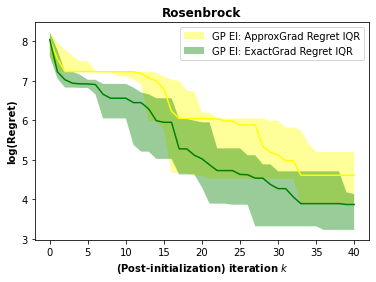

In [117]:
### Visualise!

title = func
plt.figure()

plt.plot(median_approx, color = 'Yellow')
plt.plot(median_exact, color = 'Green')

xstar = np.arange(0, iters+1, step=1)
plt.fill_between(xstar, lower_approx, upper_approx, facecolor = 'Yellow', alpha=0.4, label='GP EI: ApproxGrad Regret IQR')
plt.fill_between(xstar, lower_exact, upper_exact, facecolor = 'Green', alpha=0.4, label='GP EI: ExactGrad Regret IQR')

plt.title(title, weight = 'bold')
plt.xlabel('(Post-initialization) iteration $\it{k}$', weight = 'bold')
plt.ylabel('log(Regret)', weight = 'bold') 
plt.legend(loc=1) # add plot legend

### Make the x-ticks integers, not floats:
count = len(xstar)
plt.xticks(np.arange(0, count, 5))
plt.show() #visualise!

In [118]:
time_approx, time_exact


(841.981899023056, 1608.092319726944)

In [119]:
np.round(exact_1.acqfunc(Xstar)[0],2).reshape(50,10)


array([[-0., -0., -0., -0., -0., -0., -0., -0., -0., -0.],
       [-0., -0., -0., -0., -0., -0., -0., -0., -0., -0.],
       [-0., -0., -0., -0., -0., -0., -0., -0., -0., -0.],
       [-0., -0., -0., -0., -0., -0., -0., -0., -0., -0.],
       [-0., -0., -0., -0., -0., -0., -0., -0., -0., -0.],
       [-0., -0., -0., -0., -0., -0., -0., -0., -0., -0.],
       [-0., -0., -0., -0., -0., -0., -0., -0., -0., -0.],
       [-0., -0., -0., -0., -0., -0., -0., -0., -0., -0.],
       [-0., -0., -0., -0., -0., -0., -0., -0., -0., -0.],
       [-0., -0., -0., -0., -0., -0., -0., -0., -0., -0.],
       [-0., -0., -0., -0., -0., -0., -0., -0., -0., -0.],
       [-0., -0., -0., -0., -0., -0., -0., -0., -0., -0.],
       [-0., -0., -0., -0., -0., -0., -0., -0., -0., -0.],
       [-0., -0., -0., -0., -0., -0., -0., -0., -0., -0.],
       [-0., -0., -0., -0., -0., -0., -0., -0., -0., -0.],
       [-0., -0., -0., -0., -0., -0., -0., -0., -0., -0.],
       [-0., -0., -0., -0., -0., -0., -0., -0., -0., -0.

In [120]:
np.round(approx_1._acqWrapper(Xstar),2).reshape(50,10)


array([[-0., -0., -0., -0., -0., -0., -0., -0., -0., -0.],
       [-0., -0., -0., -0., -0., -0., -0., -0., -0., -0.],
       [-0., -0., -0., -0., -0., -0., -0., -0., -0., -0.],
       [-0., -0., -0., -0., -0., -0., -0., -0., -0., -0.],
       [-0., -0., -0., -0., -0., -0., -0., -0., -0., -0.],
       [-0., -0., -0., -0., -0., -0., -0., -0., -0., -0.],
       [-0., -0., -0., -0., -0., -0., -0., -0., -0., -0.],
       [-0., -0., -0., -0., -0., -0., -0., -0., -0., -0.],
       [-0., -0., -0., -0., -0., -0., -0., -0., -0., -0.],
       [-0., -0., -0., -0., -0., -0., -0., -0., -0., -0.],
       [-0., -0., -0., -0., -0., -0., -0., -0., -0., -0.],
       [-0., -0., -0., -0., -0., -0., -0., -0., -0., -0.],
       [-0., -0., -0., -0., -0., -0., -0., -0., -0., -0.],
       [-0., -0., -0., -0., -0., -0., -0., -0., -0., -0.],
       [-0., -0., -0., -0., -0., -0., -0., -0., -0., -0.],
       [-0., -0., -0., -0., -0., -0., -0., -0., -0., -0.],
       [-0., -0., -0., -0., -0., -0., -0., -0., -0., -0.

In [121]:
np.mean(exact_1.acqfunc(Xstar)[0]), np.mean(approx_1._acqWrapper(Xstar))


(0.0, 0.0)

In [122]:
exact_1.acqfunc(Xstar)[1].shape


(500, 4)

In [123]:
np.round(exact_1.acqfunc(Xstar)[1],2) 


array([[-0., -0., -0., -0.],
       [-0., -0., -0., -0.],
       [-0., -0., -0., -0.],
       ...,
       [-0., -0., -0., -0.],
       [-0., -0., -0., -0.],
       [-0., -0., -0., -0.]])

In [124]:
np.mean(exact_1.acqfunc(Xstar)[1])


0.0